# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_seq_items = 100

import numpy as np
np.random.seed(42)

from tqdm.notebook import tqdm
from tabulate import tabulate
import missingno as msno

TITLE_SIZE = 24
TITLE_PAD = 20

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

from sklearn.inspection import permutation_importance

import lightgbm as lgb

# Spaceship Titanic
---

![](_img/space_01.jpg)
<sub><sup>Photo by <a href="https://unsplash.com/@aperturevintage?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Aperture Vintage</a> on <a href="https://unsplash.com/collections/4332580/space?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a><sub><sup>

Kaggle's **[«Spaceship Titanic» challenge](https://www.kaggle.com/competitions/spaceship-titanic/overview)** was published around spring 2022 as a follow-up to the very popular and ubiquitous [Titanic challenge](https://www.kaggle.com/c/titanic/overview). 

The dataset for this new challenge is fictitious and has been generated entirely from scratch. 

The back story goes like this:

> *Welcome to the year 2912. The **Spaceship Titanic** is an interstellar passenger liner. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri the ship collided with a spacetime anomaly. It met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension.*

To help *«rescue crews and retrieve the lost passengers»*, data scientists are challenged to predict which passengers were transported by the anomaly and which are not.

I was curious how Kaggles staff updated the Titanic story. I made a quick EDA and did some test runs with a couple of classifiers.  

#### Some thoughts:

- I perceive Spaceship Titanic as **a much-needed replacement for the original Titanic data set**. 
- The original can be seen as a lightweight, beginner-friendly classification task with now literally tens of thousands of reference solutions. 
- However, **it always felt somewhat macabre and ethically dubious to work on the fate of many dead people.** Why exactly this catastrophe? What is the point and what relevant insights did we gain (beyond learning some data cleaning and modeling)? 
- Spaceship Titanic elegantly **solves this issue by projecting a similar story into a fictitious future**. 
- The new data is **bigger and somewhat broader in scope**. 
- The data is quite aptly designed so that people can try out a lot of the relevant data preparation and modeling steps. 
- It is **complicated enough to be interesting but can be grasped in a couple of hours or a few days to not overwhelm**. 
- In contrast to the old data set the **test data is not known – a huge plus in terms of fairness** since solutions can not be handcoded any more. 

I enjoyed this quick peek into the Spaceship Titanic data. I perceive the idea of synthetic data sets for learning and competitions as quite compelling. So kudos to the Kaggle team behind that!


# EDA

First let's have a look at the **[data description](https://www.kaggle.com/competitions/spaceship-titanic/data)** which already gives us a lot of information about the **data structure and content**:

- `passengerid` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `homeplanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `cryosleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `destination` - The planet the passenger will be debarking to.
- `age` - The age of the passenger.
- `vip` - Whether the passenger has paid for VIP service during the voyage.
- `roomservice`, `foodcourt`, `shoppingmall`, `spa`, `vrdeck` - The amount of money the passenger has billed at each of the amenities.
- `name` - First and last names of the passenger.
- `transported` - Whether the passenger was transported to another dimension. This is the target variable that we need to predict.

## Data structure

In [3]:
train = pd.read_csv("_data/train.csv")
test = pd.read_csv("_data/test.csv")

# concatenate to one dataframe to analyze the whole data set
df = pd.concat([train, test]).reset_index(drop=True)

# set column names to lowercase for easier handling of the dataframe
df.columns = df.columns.str.lower()

- We have a total of **12,970 samples with 14 features**.
- **We have training data for 8'693 passengers** and **test data for 4'277 passengers**. 
- **6 features are numerical** and **8 are categorical** including the target variable `transported`. 

In [4]:
print(f"The combined data set contains a total of {df.shape[0]:,.0f} samples with {df.shape[1]} features.")
print(f"There are {df.select_dtypes('object').shape[1]} categorical and {df.select_dtypes('number').shape[1]} numerical features")

The combined data set contains a total of 12,970 samples with 14 features.
There are 8 categorical and 6 numerical features


A first look at some samples reveals compound features like `passengerid` and `cabin` that we likely have to split into their components.

In [5]:
display(df.head())

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Data quality

### Duplicates
There are **no exact duplicates**.

In [6]:
exact_duplicates = df.duplicated().sum()
print(f"We have {exact_duplicates} exact duplicates in the data set.\n")

We have 0 exact duplicates in the data set.



### Missing data
We can see that **data is missing for several features**.

In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   12970 non-null  object 
 1   homeplanet    12682 non-null  object 
 2   cryosleep     12660 non-null  object 
 3   cabin         12671 non-null  object 
 4   destination   12696 non-null  object 
 5   age           12700 non-null  float64
 6   vip           12674 non-null  object 
 7   roomservice   12707 non-null  float64
 8   foodcourt     12681 non-null  float64
 9   shoppingmall  12664 non-null  float64
 10  spa           12686 non-null  float64
 11  vrdeck        12702 non-null  float64
 12  name          12676 non-null  object 
 13  transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


None

Visualizing the data with `missingno` shows that the missing data is at the «lower» end of the train and test data.

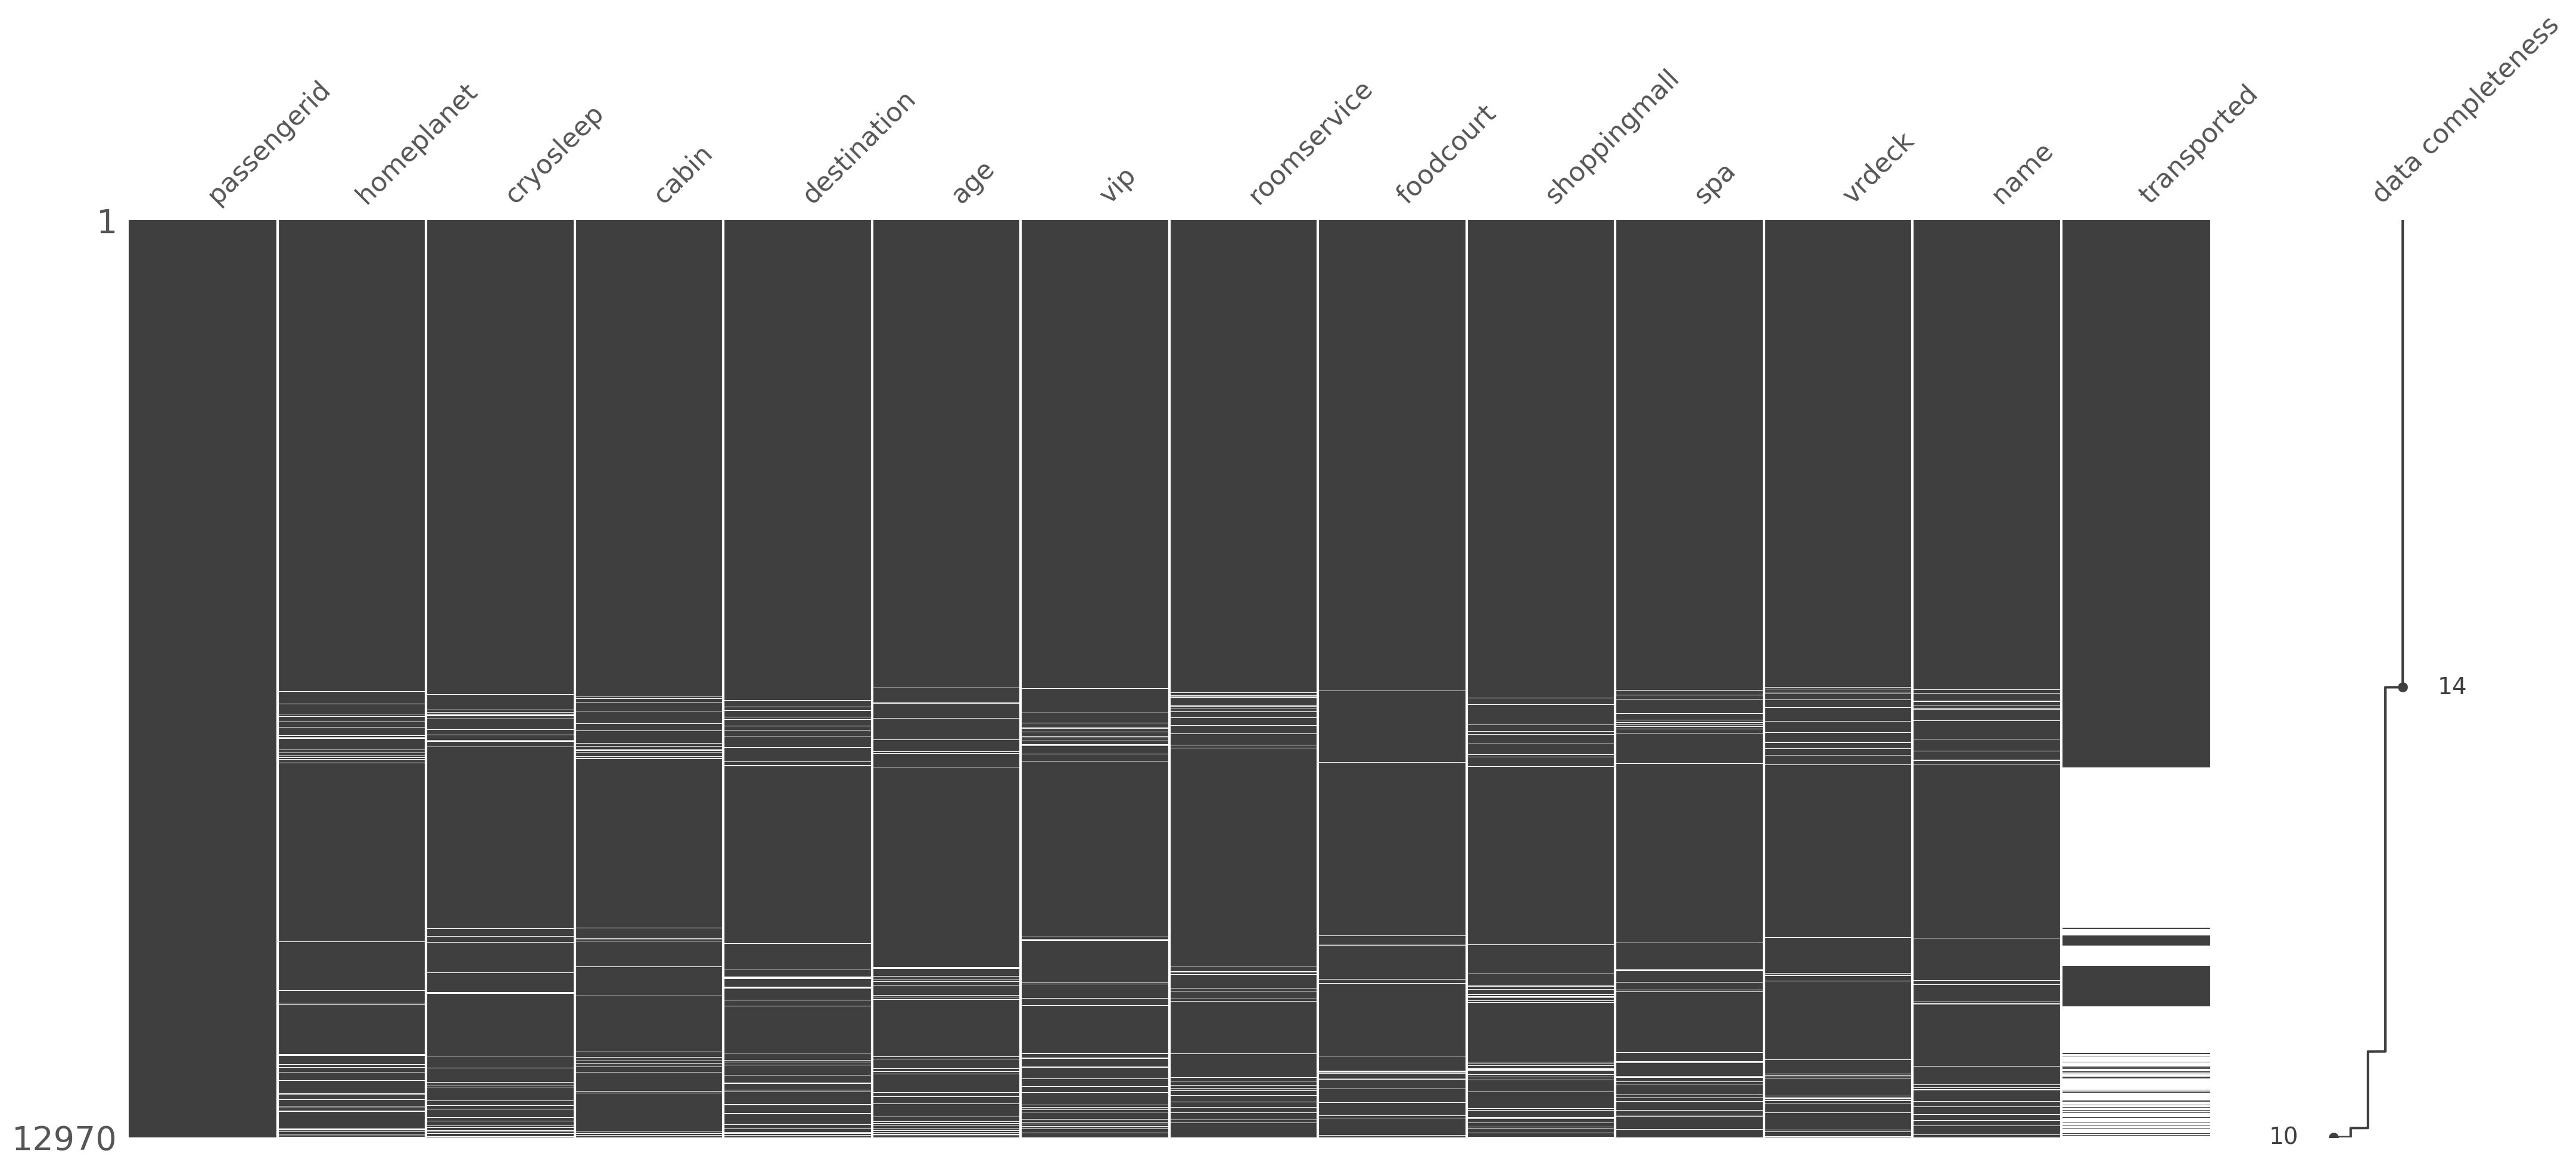

In [8]:
msno.matrix(df, labels=True, sort="descending")
plt.show()

Closer examination reveals:
- **Between 2% to 2.4% of data is missing** in 12 of the 13 features in the combined data (train and test).
- **The difference in the amount of missing data between test and training data seems similar.**

In [9]:
missing = [(c, df[c].isna().mean()*100) for c in df.drop("transported", axis=1)]
missing_train = [(c, train[c].isna().mean()*100) for c in train]
missing_test = [(c, test[c].isna().mean()*100) for c in test]

missing = pd.DataFrame(missing, columns=["column_name", "full_data"])
missing_train = pd.DataFrame(missing_train, columns=["column_name", "train_data"])
missing_test = pd.DataFrame(missing_test, columns=["column_name", "test_data"])
missing = pd.concat([missing, missing_train.train_data, missing_test.test_data], axis=1)

missing = missing[missing["full_data"] > 0].sort_values("full_data", ascending=False)
print("Percentage of missing values")
print(tabulate(missing, floatfmt=".1f", showindex=False, headers="keys"))

Percentage of missing values
column_name      full_data    train_data    test_data
-------------  -----------  ------------  -----------
cryosleep              2.4           2.5          2.2
shoppingmall           2.4           2.4          2.3
cabin                  2.3           2.3          2.3
vip                    2.3           2.3          2.2
name                   2.3           2.3          2.2
foodcourt              2.2           2.1          2.5
homeplanet             2.2           2.3          2.0
spa                    2.2           2.1          2.4
destination            2.1           2.1          2.2
age                    2.1           2.1          2.1
vrdeck                 2.1           2.2          1.9
roomservice            2.0           2.1          1.9


### Unwanted entries or recording errors

Since this is a fictional and synthetic dataset it is not very likely that we have erroneous samples.

Plotting all **numerical samples** we can see some outlying data points, e.g. values for room service above 14'000 or shoppingmall for more than 20'000.

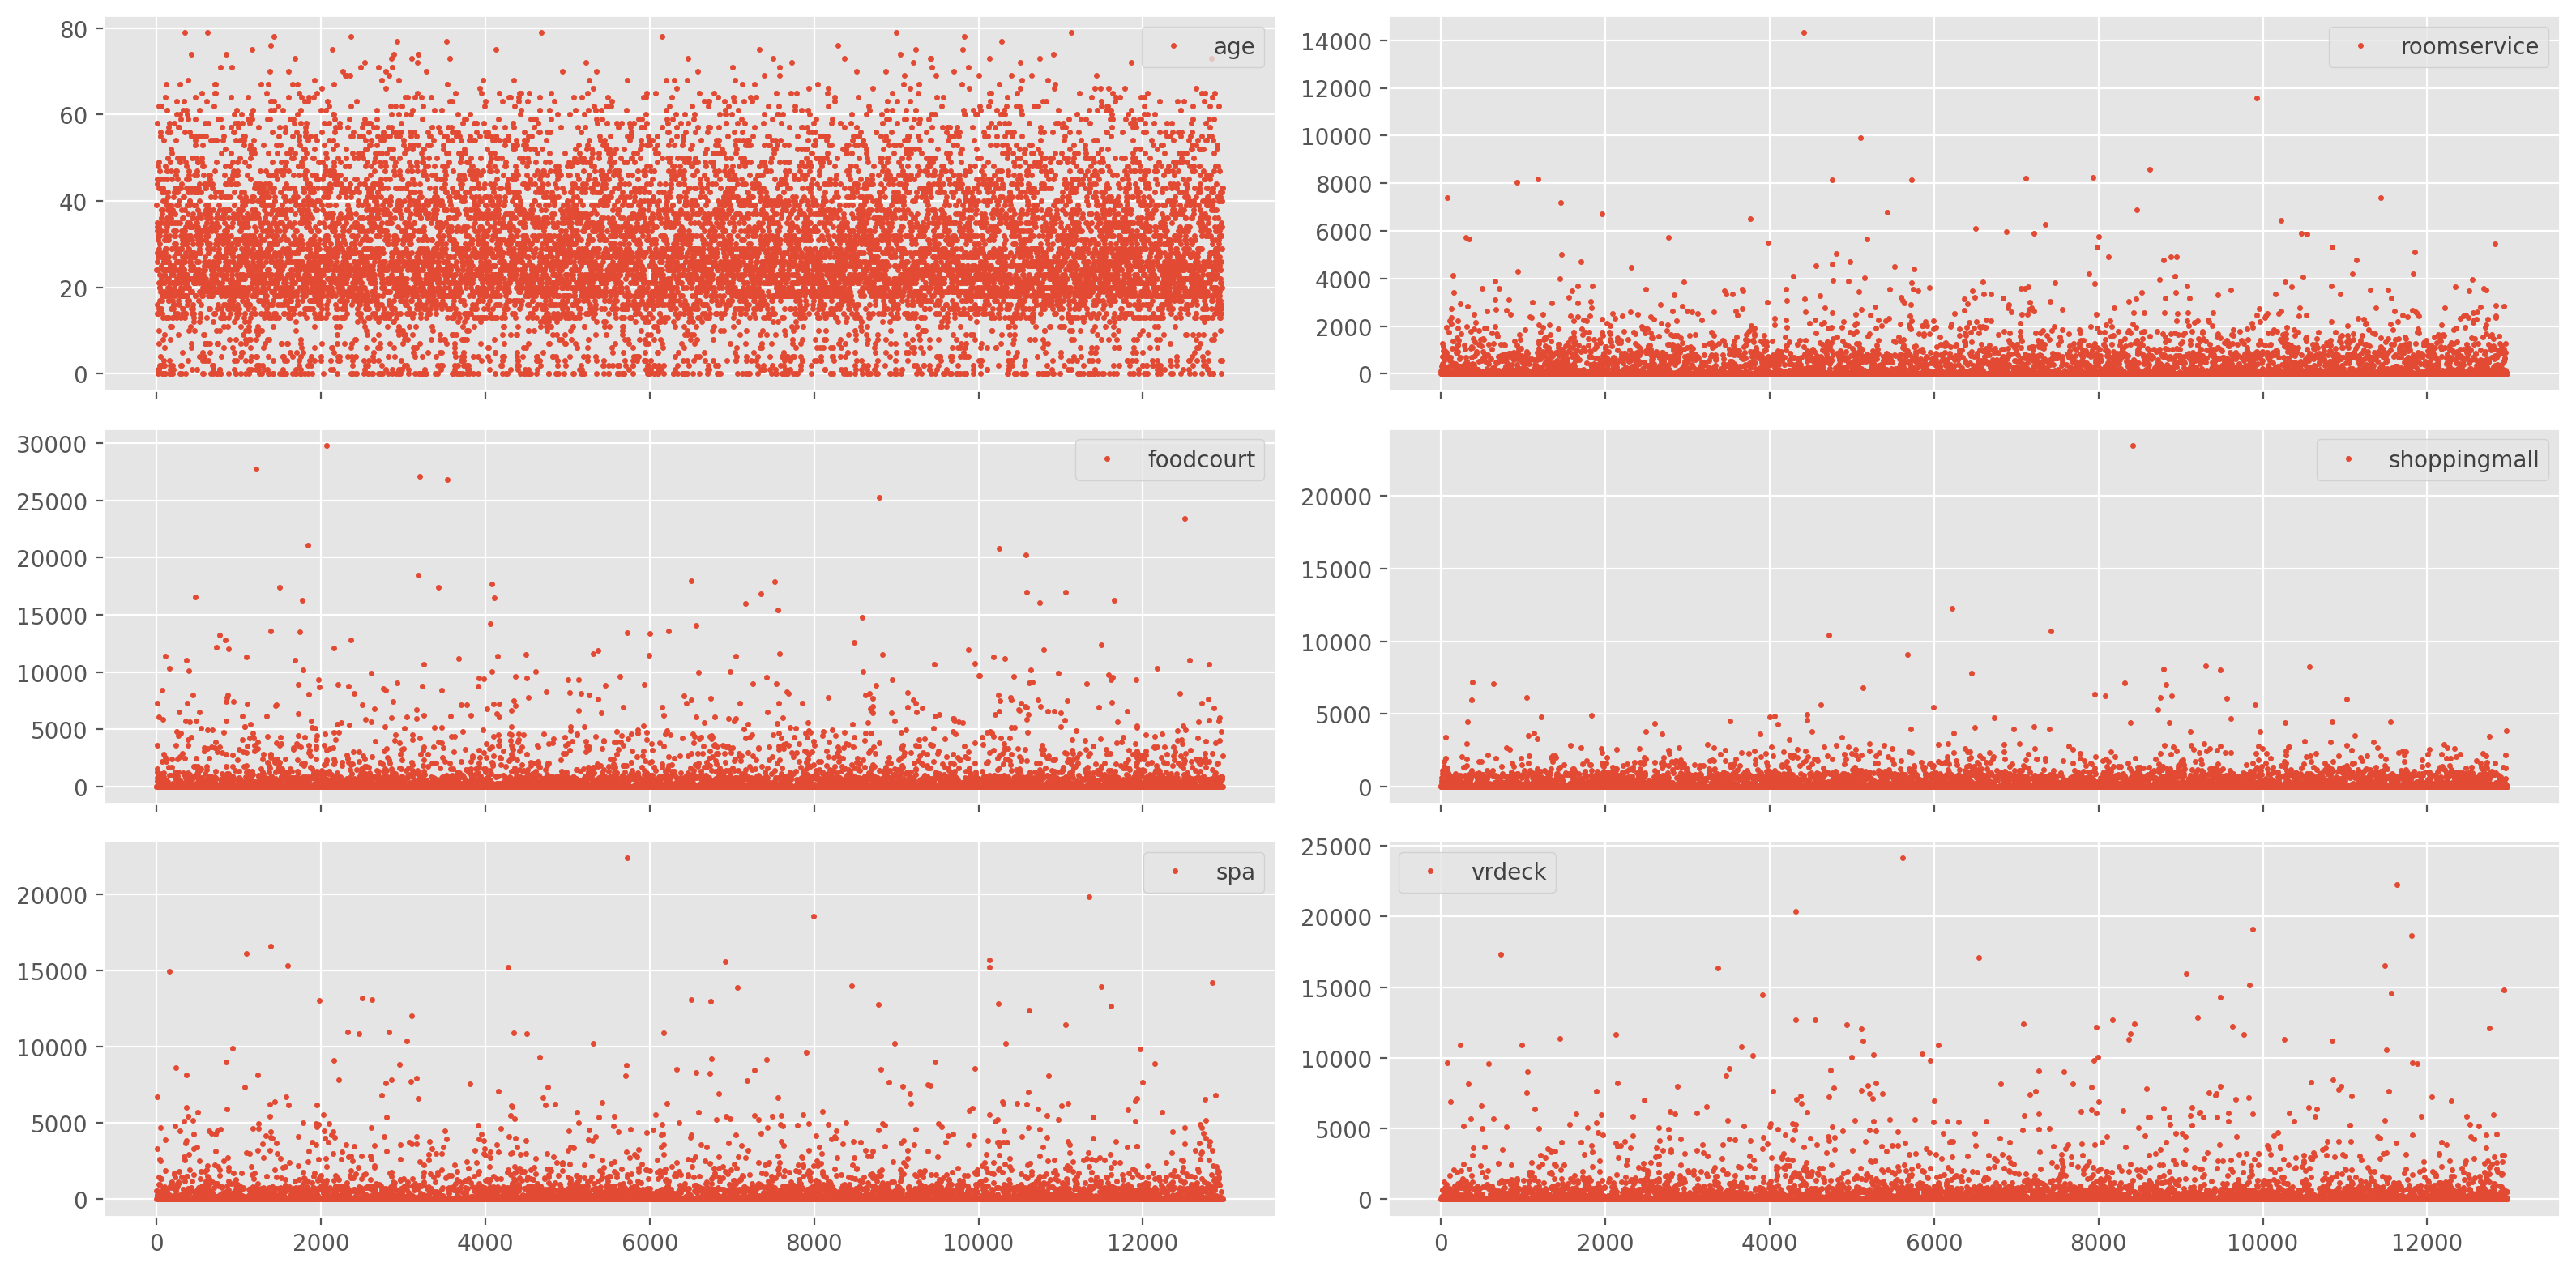

In [10]:
df.plot(lw=0, marker=".", subplots=True, markersize=3, figsize=(16, 8), layout=(-1, 2), color=DEFAULT_COLORS[0])
plt.tight_layout()
plt.show()

Counting unique categorical values gives no indication for errors.

In [11]:
df.select_dtypes(include="object").nunique().sort_values()

cryosleep          2
vip                2
transported        2
homeplanet         3
destination        3
cabin           9825
name           12629
passengerid    12970
dtype: int64

Lets quickly split the ids and cabin numbers.

In [12]:
tmp = df.cabin.dropna().str.split("/", expand=True)
display(tmp.head())

,0,1,2
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S


No suprises here neither. We have 8 decks, 2 sides and a lot of unique cabin numbers.

In [13]:
display(tmp.nunique())

0       8
1    1894
2       2
dtype: int64

## Content

We now prepare some of the variables for further **content exploration**. 

In [14]:
# create feature of total spendings per passenger
expenses = ["foodcourt", "shoppingmall", "roomservice", "spa", "vrdeck"]
df["spent_total"] = df[expenses].sum(axis=1)

# create feature to indicate passengers age 13 and above who can spend
age_limit_for_spending = 13
df["can_spend"] = np.where(df.age >= age_limit_for_spending, True, False)

# split passenger IDs into group ID and number of passenger in group
df[["group", "group_no"]] = df.passengerid.str.split("_", expand=True)
df.group_no = df.group_no.apply(lambda x: int(x))

# create a feature for the size of each group
tmp = df.groupby("group").group.count()
df["group_size"] = df.group.map(dict(tmp))

# calculate total of group spending
tmp = df.groupby("group").spent_total.sum()
df["group_spent_total"] = df.group.map(tmp)

# split cabin string into deck, cabin number and side of ship
df[["cabin_deck", "cabin_num", "cabin_side"]] = df.cabin.str.split("/", expand=True)
df.cabin_num = df.cabin_num.apply(lambda x: int(x) if type(x)==str else np.nan)

# create a feature for cabin size
tmp = df.cabin.value_counts()
df["cabin_size"] = df.cabin.map(tmp)

# bin ages of passengers
rng = range(0, 85, 5)
df["age_bins"] = pd.cut(df.age, rng)
df.age_bins = df.age_bins.apply(lambda x: x.left)

# create feature of total spending of passenger
expenses = ["roomservice", "foodcourt", "shoppingmall", "spa", "vrdeck"]
df["spent_total"] = df[expenses].sum(axis=1)

# split names in first and last name to identify family relationships
df[["name_first", "name_last"]] = df.name.str.split(" ", expand=True)

train = df[df.transported.notna()]
test = df[df.transported.isna()]

**Let's print out value counts for all variables to get a better sense of the content.**

In [15]:
for c in df.columns:
    print(c)
    display(df[c].value_counts())
    print()

### Examining all features one by one

#### `passengerid` and derived group features

In [16]:
# Are all passenger IDs unique? Yes, they are...
assert df.passengerid.value_counts().unique()[0] == 1

In [17]:
print(f"There are {df.group.nunique():,.0f} distinct passenger groups.")
print(f"There are {df.passengerid.isna().sum():.0f} missing values.")

There are 9,280 distinct passenger groups.
There are 0 missing values.


**Groups do not overlap between train and test data.**

In [18]:
in_test = set(df[df.transported.isna()].group.unique().tolist())
not_in_test = set(df[df.transported.notna()].group.unique().tolist())
print(f"{len(set.intersection(in_test, not_in_test))} groups are both in the train and the test set.")

0 groups are both in the train and the test set.


- **Passenger groups have sizes between 1 and 8 passengers.**
- **Groups occupy between 1 and 3 cabins.**
- More than half of the passengers (55.1%) travel alone. 
- There are 20% of passengers travelling with one companion, 11.6% are in a group of three. 

Groups can occupy between 1 and 3 cabins.

Percentage of passenger group sizes
-  ----
1  55.1
2  20.0
3  11.6
4   4.7
5   2.9
6   1.9
7   2.5
8   1.2
-  ----


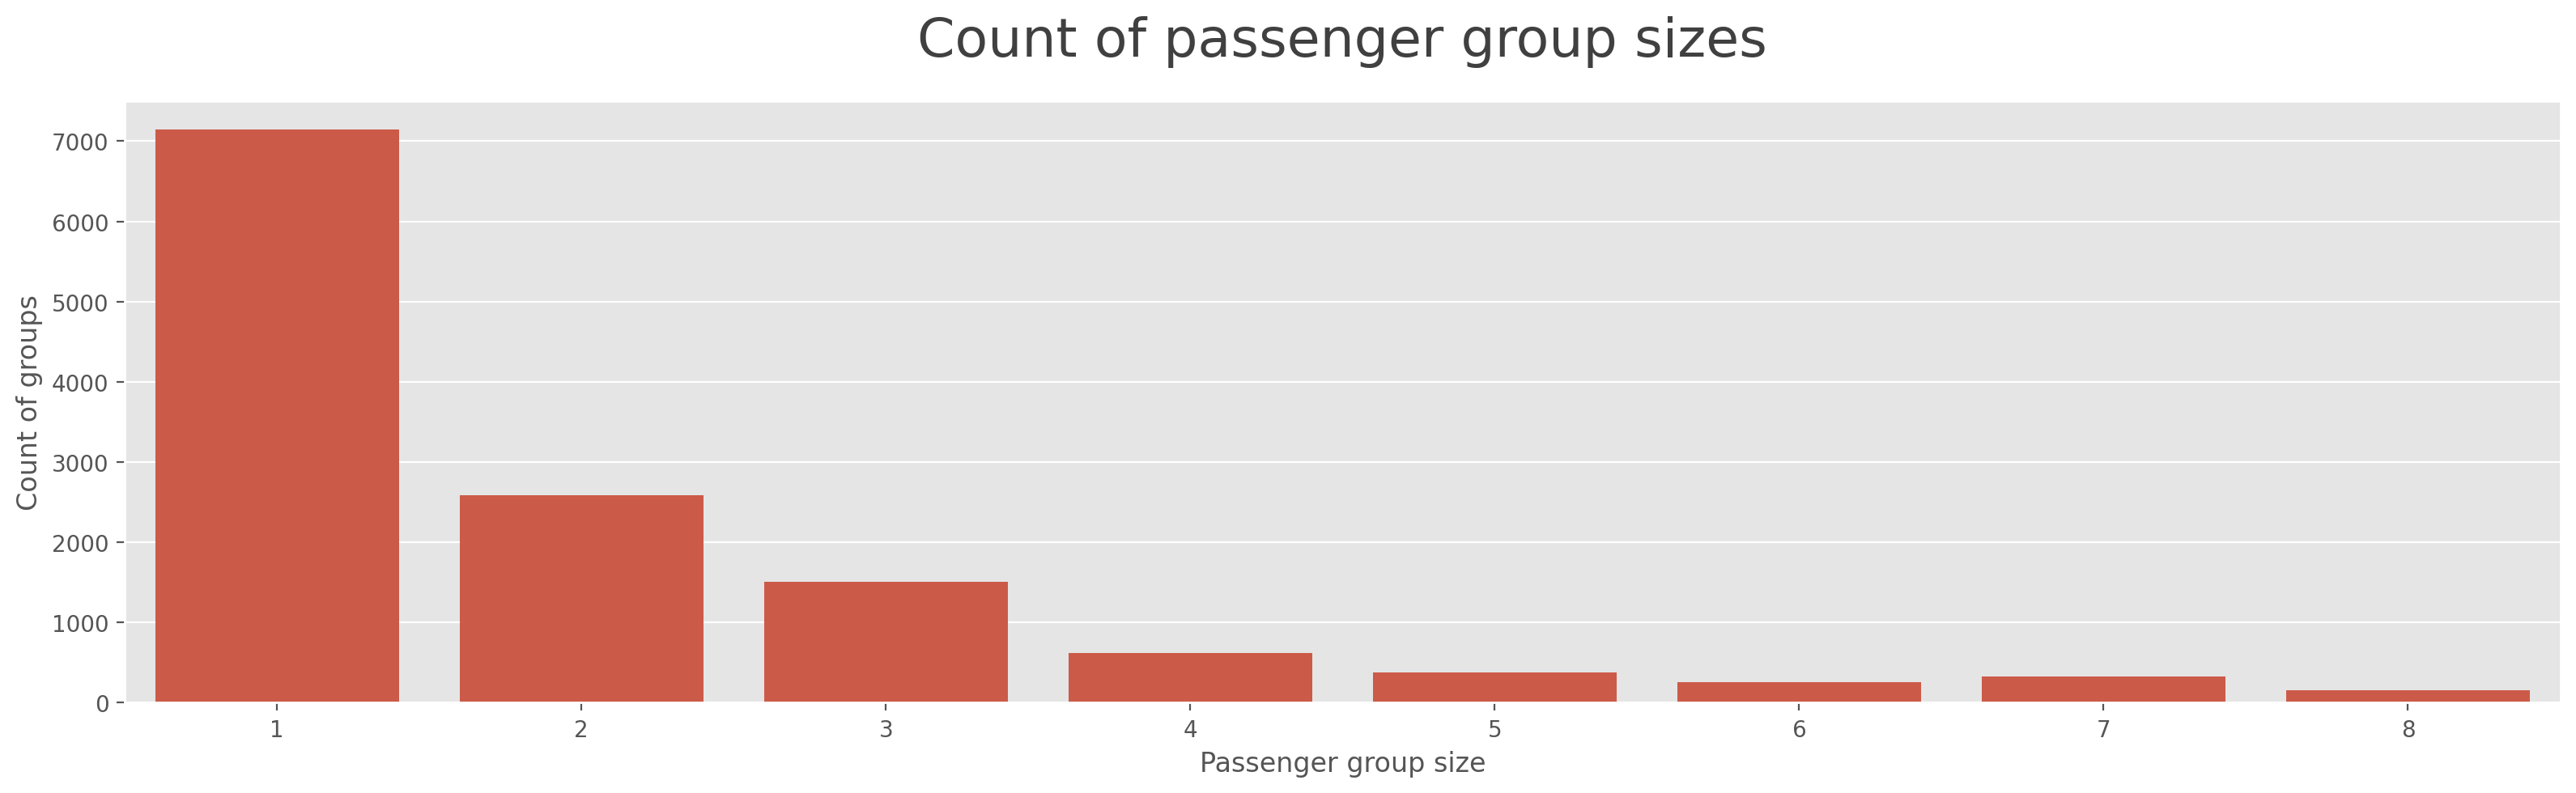

In [19]:
tmp = df.dropna(subset=["cabin"]).groupby("group").cabin.nunique().unique().tolist()
print(f"Groups can occupy between {np.min(tmp)} and {np.max(tmp)} cabins.\n")

tmp = df.group_size.value_counts(normalize=True).sort_index()
print("Percentage of passenger group sizes")
print(tabulate(pd.DataFrame(tmp*100), floatfmt=".1f"))

tmp = df.group_size.value_counts()
plt.figure(figsize=(16, 5))
sns.barplot(y=tmp.values, x=tmp.index, color=DEFAULT_COLORS[0])
plt.title("Count of passenger group sizes", size=TITLE_SIZE, pad=TITLE_PAD)
plt.ylabel("Count of groups")
plt.xlabel("Passenger group size")
plt.tight_layout()
plt.show()

The anomaly has affected single travellers as well as partial and entire groups.

In [20]:
single_passengers_affected = df[(df.group_size==1) & (df.transported==1)].shape[0]

g = df[df.transported.notna()].groupby("group")

entire_groups_affected = []
partial_groups_affected = []

for n, data in g:
    if data.group_size.mean()>1:
        if data.transported.sum() == data.group_size.mean():
            entire_groups_affected.append((data.group.unique()[0], data.transported.sum()))
        else:
            partial_groups_affected.append((data.group.unique()[0], data.transported.sum()))
            
entire_groups_affected = pd.DataFrame(entire_groups_affected)
partial_groups_affected = pd.DataFrame(partial_groups_affected)

print("The anomaly has affected:")
print(f"- {single_passengers_affected:,.0f} passengers travelling alone.")
print(f"-   {entire_groups_affected.sum()[1]} passengers in   {len(entire_groups_affected)} groups that were affected entirely.")
print(f"- {partial_groups_affected.sum()[1]:,.0f} passengers in {len(partial_groups_affected):,.0f} groups that were affected only partially.")

The anomaly has affected:
- 2,174 passengers travelling alone.
-   916 passengers in   378 groups that were affected entirely.
- 1,288 passengers in 1,034 groups that were affected only partially.


In [21]:
# Assert that we have found all affected passengers
assert train.transported.sum() == single_passengers_affected + entire_groups_affected.sum()[1] + partial_groups_affected.sum()[1]

Looking at larger groups we notice that groups can consist of people with several different last names. 

In [22]:
tmp = df.group.value_counts() > 6
df[df.group.isin(tmp[tmp==True].index)].groupby("group").name_last.value_counts()

group  name_last 
0220   Wilsoney      7
0221   Reke          6
       Blan          1
0339   Colleruces    4
       Barnolderg    3
                    ..
9081   Clemondsey    7
9157   Navages       6
       Donson        1
9238   Emenez        5
       Garnettiz     2
Name: name_last, Length: 133, dtype: int64

#### `cabin` and derived features

In [23]:
feature = "cabin"

In [24]:
def get_missing(feature):
    print(f"{df[feature].isna().sum()} missing values for feature «{feature}»\
 (train: {train[feature].isna().mean()*100:.1f}%, test: {test[feature].isna().mean()*100:.1f}%)")

In [25]:
get_missing(feature)

299 missing values for feature «cabin» (train: 2.3%, test: 2.3%)


In [26]:
print(f"The ship has {df.cabin_num.nunique():,.0f} unique cabins on {df.cabin_deck.nunique()} unique decks.")

The ship has 1,894 unique cabins on 8 unique decks.


- Decks range from `A` to `T`. 
- `T` is the smallest deck and `F` is the biggest in terms of cabin count as well as in passenger count. 

cabin_deck      cabin_count    passenger_count
------------  -------------  -----------------
A                     110.0              354.0
B                     353.0             1141.0
C                     343.0             1102.0
D                     296.0              720.0
E                     609.0             1323.0
F                    1894.0             4239.0
G                    1508.0             3781.0
T                       5.0               11.0


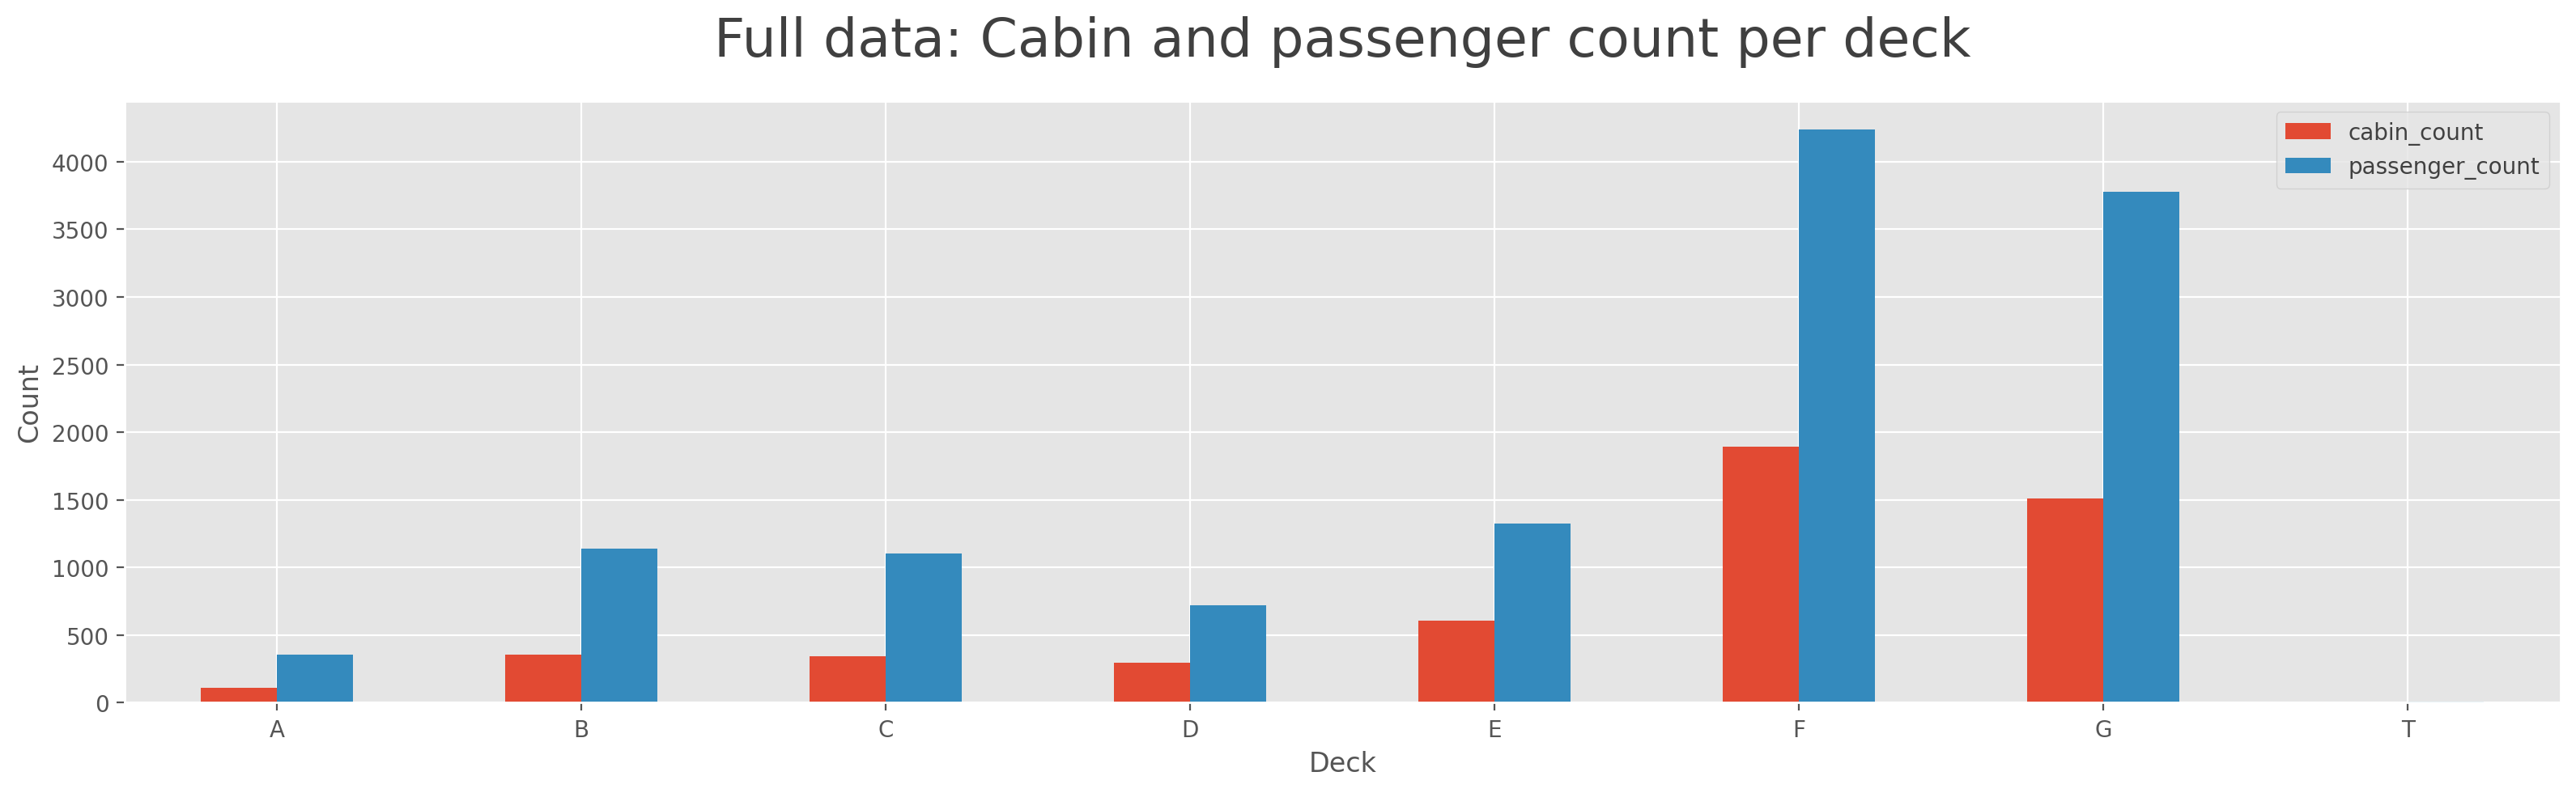

In [27]:
tmp = df.groupby("cabin_deck").cabin_num.nunique().sort_index().to_frame()
tmp.columns = ["cabin_count"]
tmp["passenger_count"] = df.groupby("cabin_deck").cabin_num.count().sort_index()

print(tabulate(tmp, headers="keys", floatfmt=".1f"))

tmp.plot.bar(figsize=(16,5))
plt.xticks(rotation=0)
plt.title("Full data: Cabin and passenger count per deck", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlabel("Deck")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

**Decks `B` and `C` overindex on transported passengers.**

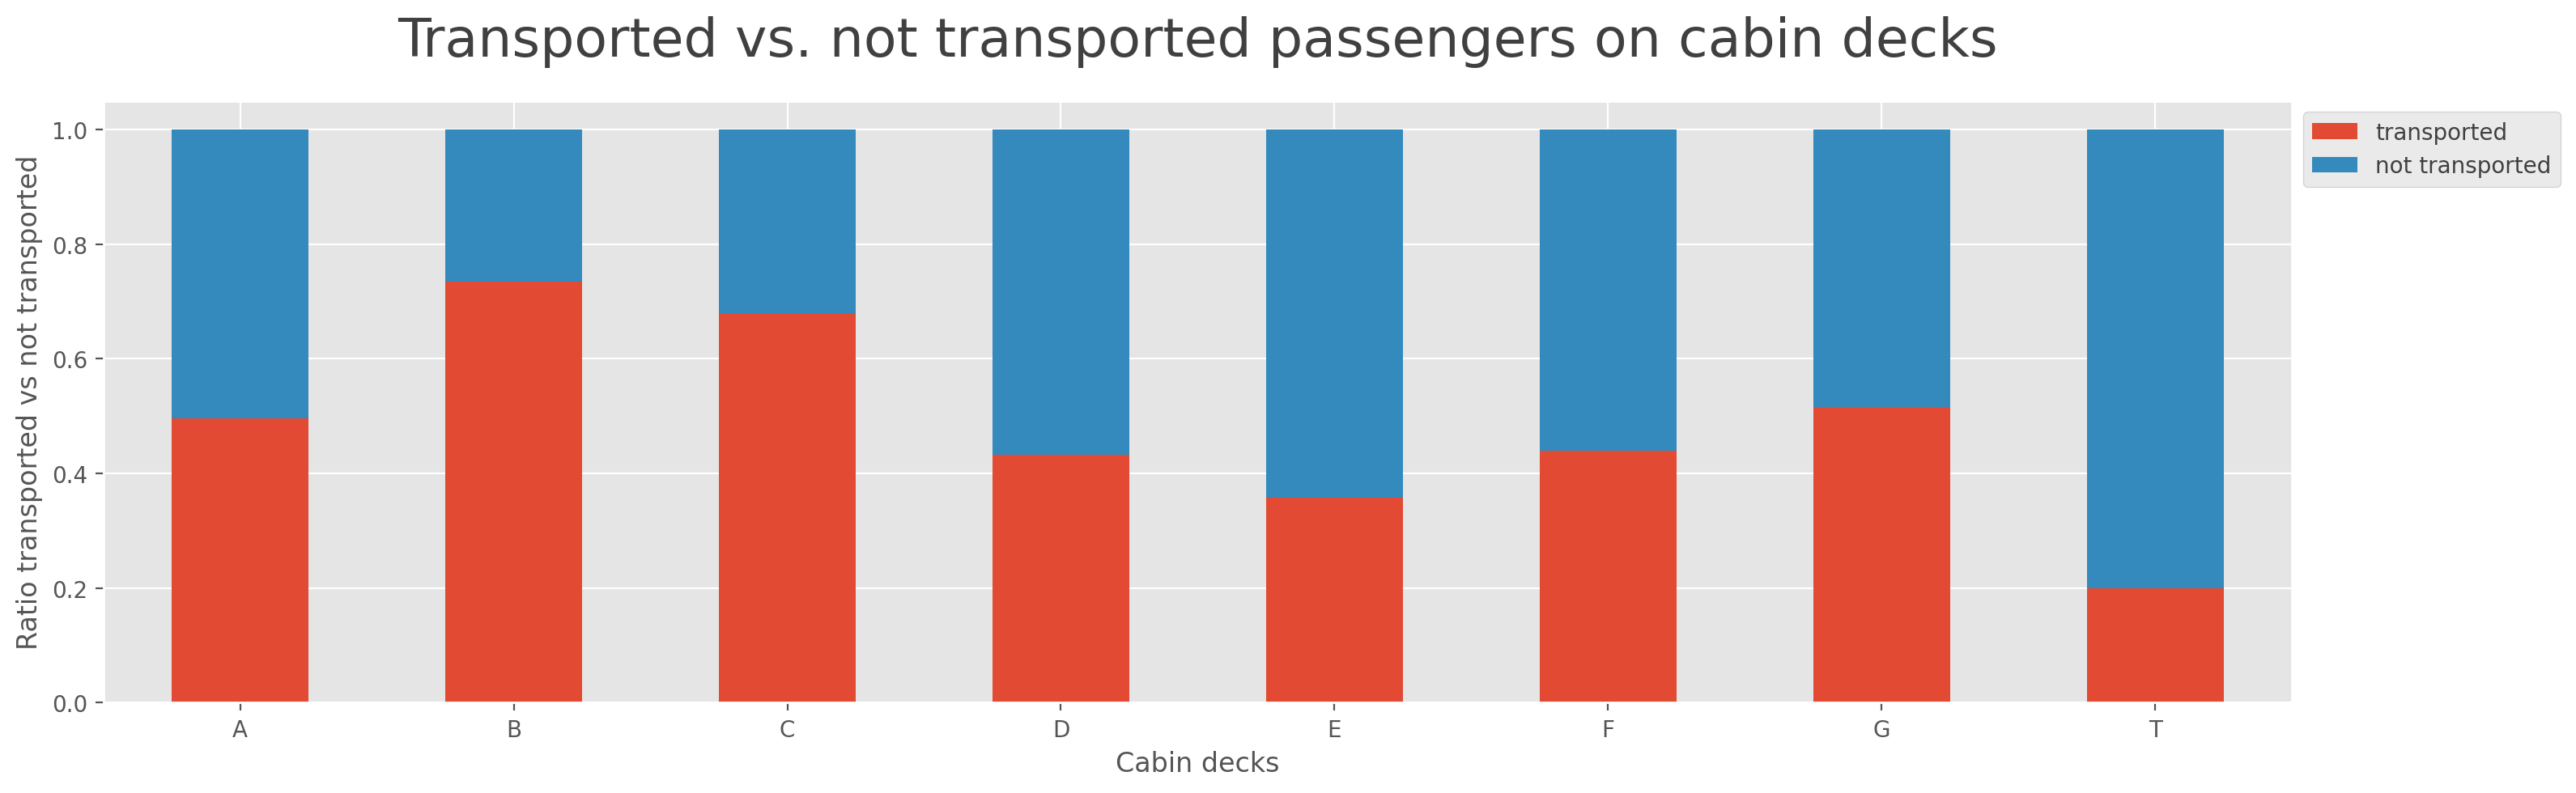

In [28]:
tmp = df.groupby("cabin_deck").transported.value_counts(normalize=True).unstack()
tmp = tmp.iloc[:, ::-1]

tmp.plot.bar(stacked=True, figsize=(16,5), color=(DEFAULT_COLORS))
plt.title("Transported vs. not transported passengers on cabin decks", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xticks(rotation=0)
plt.ylabel("Ratio transported vs not transported")
plt.xlabel("Cabin decks")
plt.legend(["transported", "not transported"], bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

By splitting the data between the two sides `P` and `S` we can see that **decks B and C on Side S have a particularly high ratio of affected passengers.**

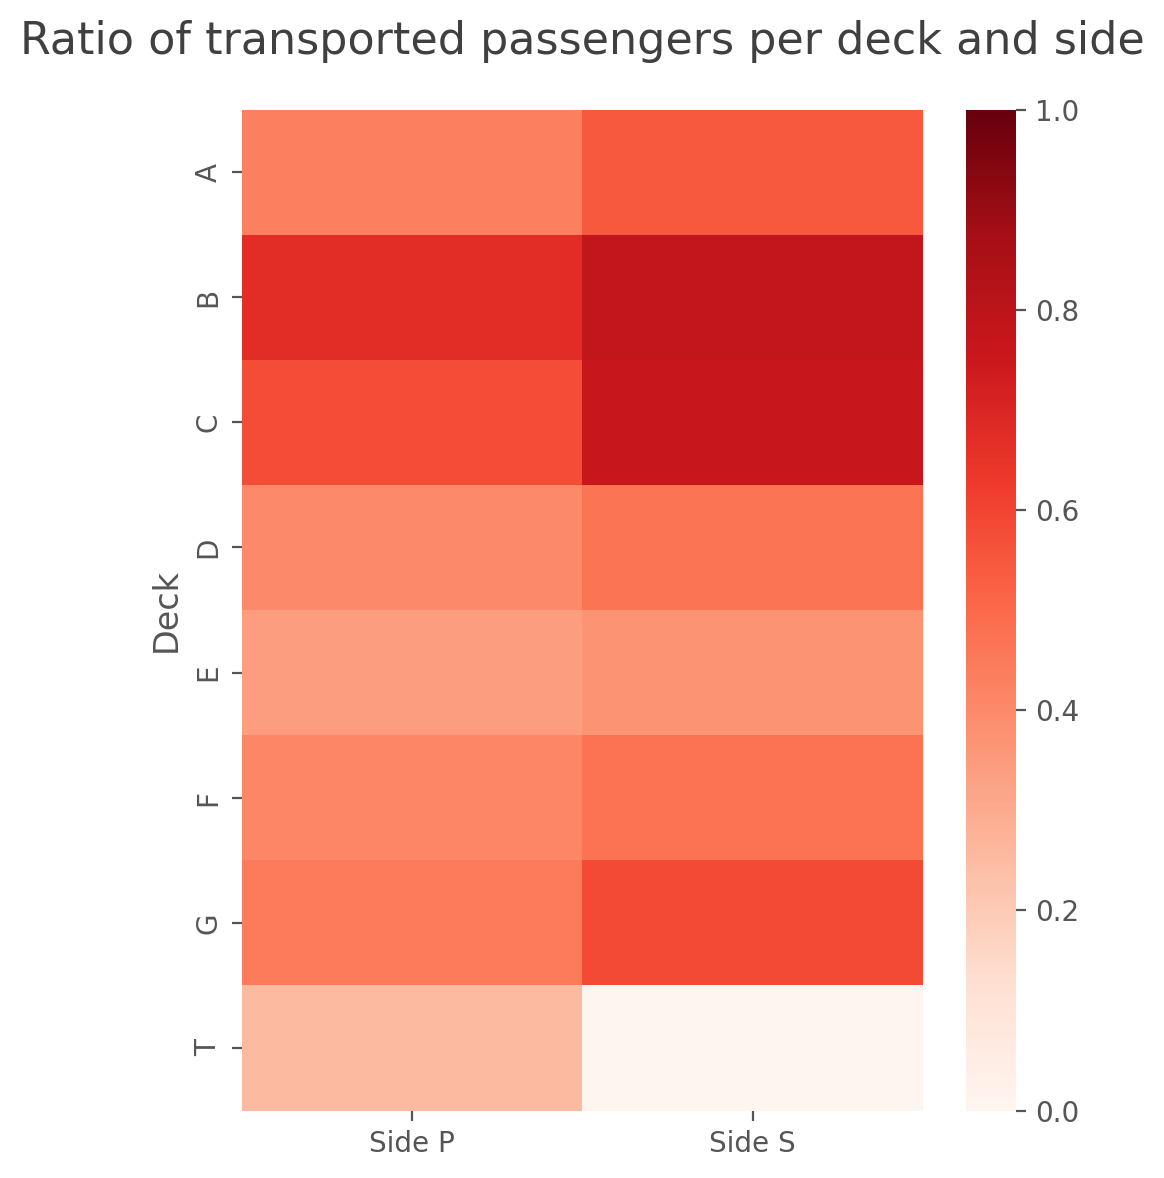

In [29]:
g = df[df.transported.notna()].groupby("cabin_deck")
tmp = g.transported.mean().sort_index().to_frame()
tmp["Side P"] = df[(df.transported.notna()) & (df.cabin_side=="P")].groupby("cabin_deck").transported.mean().sort_index()
tmp["Side S"] = df[(df.transported.notna()) & (df.cabin_side=="S")].groupby("cabin_deck").transported.mean().sort_index()

# print(tabulate(tmp*100, headers="keys", floatfmt=".1f"))
plt.figure(figsize=(5, 6))
sns.heatmap(tmp.iloc[:, 1:], vmin=0, vmax=1, cmap="Reds")
plt.title("Ratio of transported passengers per deck and side", size=16, pad=TITLE_PAD)
plt.ylabel("Deck")
plt.tight_layout()
plt.show()

Cabin numbers on all decks start with zero and continuously increase up to the highest cabin number on the respective deck and side.

In [30]:
tmp = df.groupby("cabin_deck").cabin_num.unique()
tmp = tmp.apply(lambda x: sorted(x))
print(tmp)

cabin_deck
A    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
B    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
C    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
D    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
E    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
F    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
G    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
T                            [0.0, 1.0, 2.0, 3.0, 4.0]
Name: cabin_num, dtype: object


The cabins aren't distributed symetrically. The cabin counts and cabin sizes differ significantly between port and starboard.

In [31]:
df.cabin_num

0           0.0
1           0.0
2           0.0
3           0.0
4           1.0
          ...  
12965    1496.0
12966       NaN
12967     296.0
12968     297.0
12969    1498.0
Name: cabin_num, Length: 12970, dtype: float64

In [32]:
tmp = df.groupby(["cabin_deck", "cabin_side"]).agg({'cabin_num': ['count', 'max'], 
                                                    "cabin_size": "sum"})
display(tmp)

cabin_num         cabin_size
                          count     max        sum
cabin_deck cabin_side                             
A          P                166    98.0      382.0
           S                188   109.0      432.0
B          P                512   301.0     1214.0
           S                629   353.0     1569.0
C          P                533   309.0     1311.0
           S                569   342.0     1435.0
D          P                370   297.0      628.0
           S                350   278.0      600.0
E          P                641   598.0      825.0
           S                682   608.0      976.0
F          P               2178  1894.0     3174.0
           S               2061  1796.0     2863.0
G          P               1885  1508.0     3405.0
           S               1896  1500.0     3550.0
T          P                  5     4.0        5.0
           S                  6     3.0       12.0

There seems to be no obvious pattern in the distribution of the cabins.

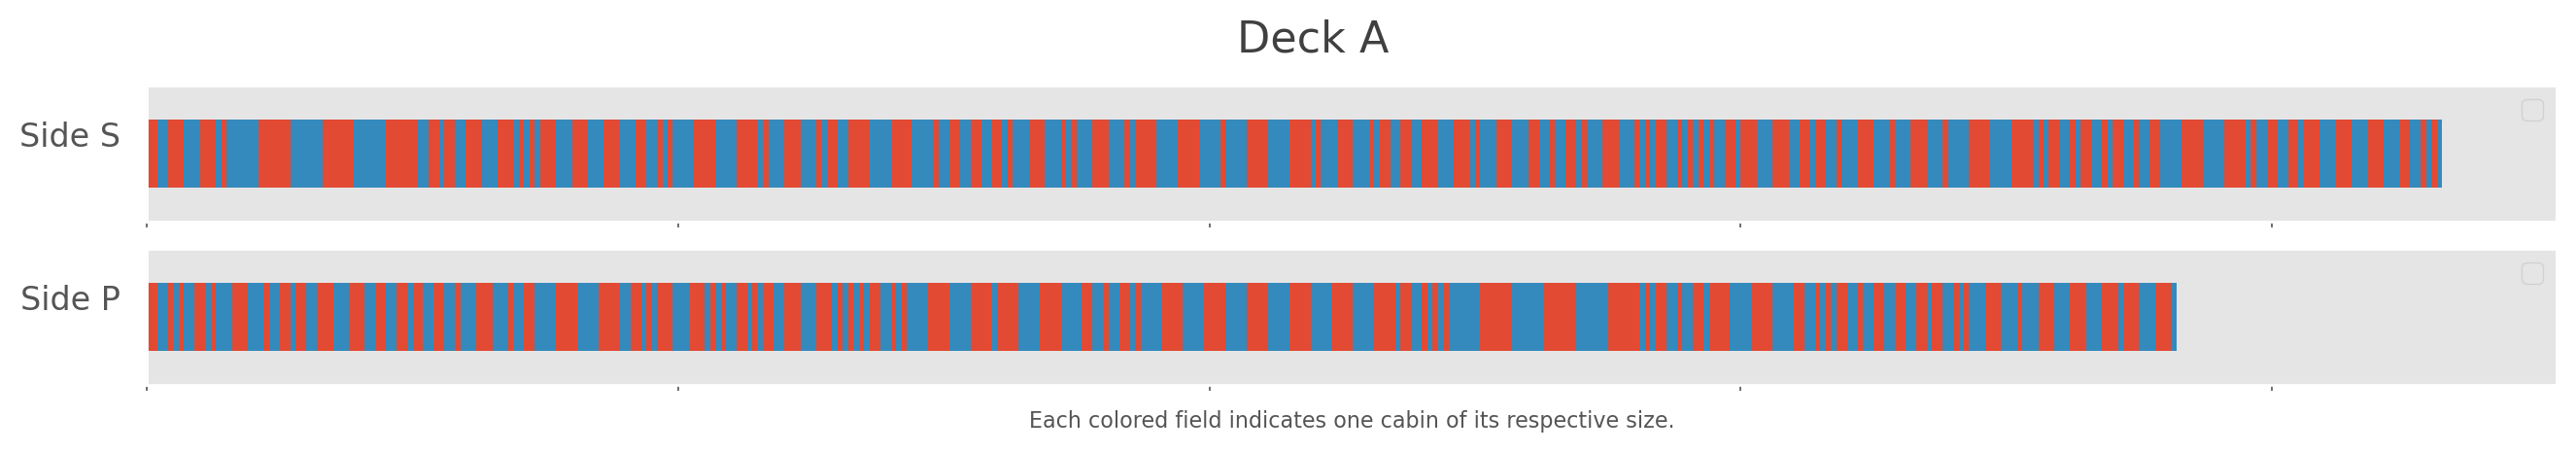

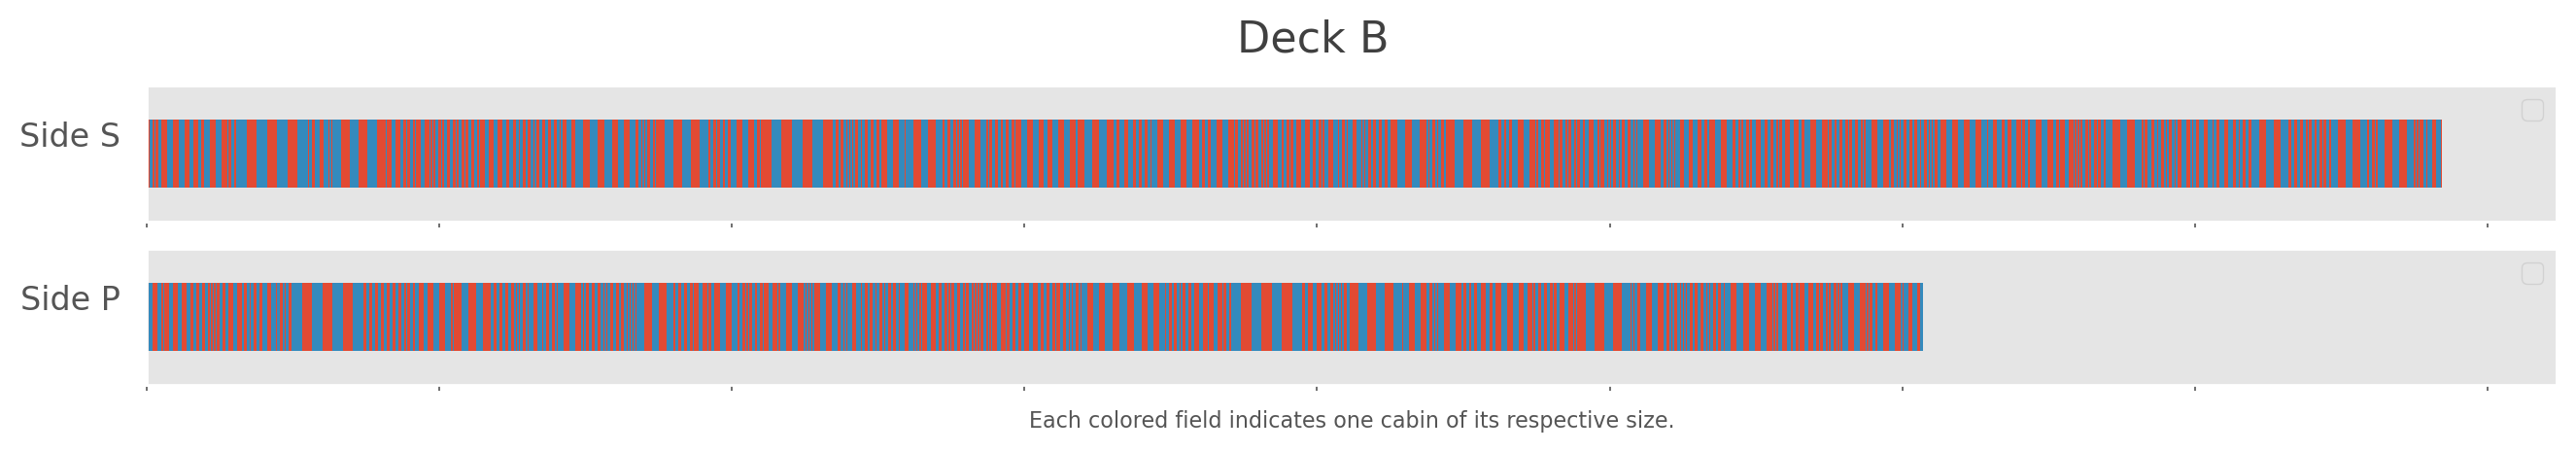

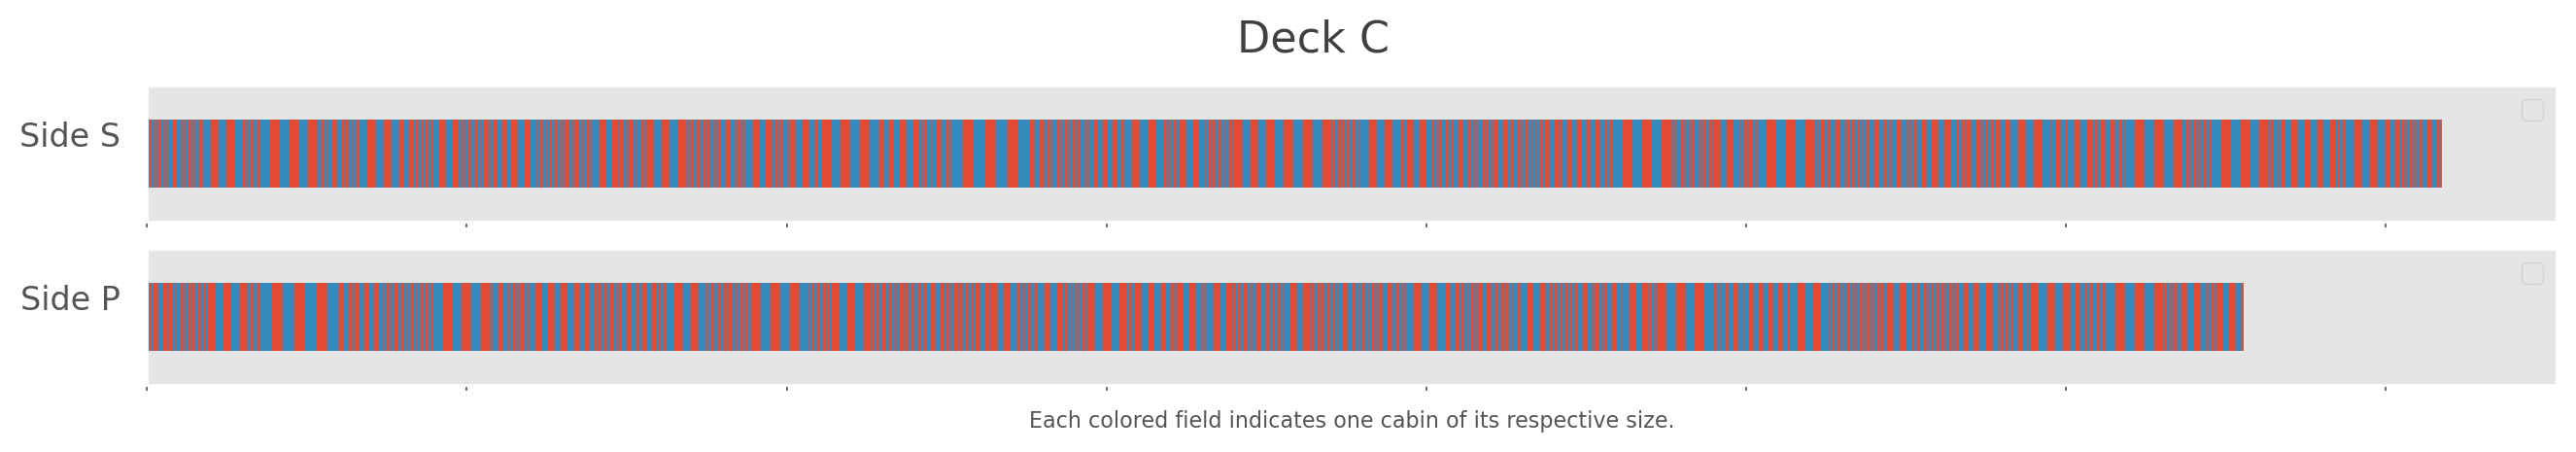

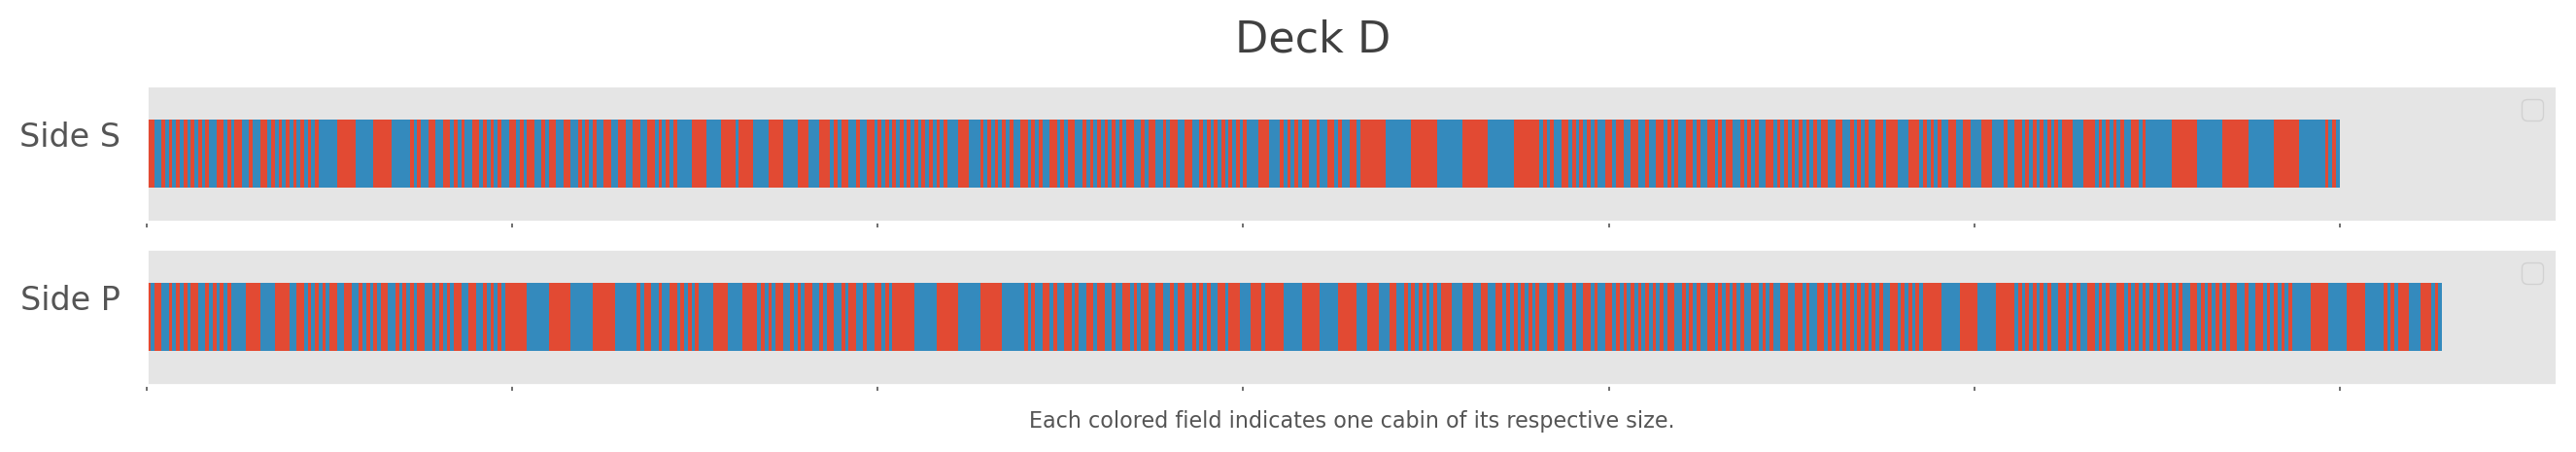

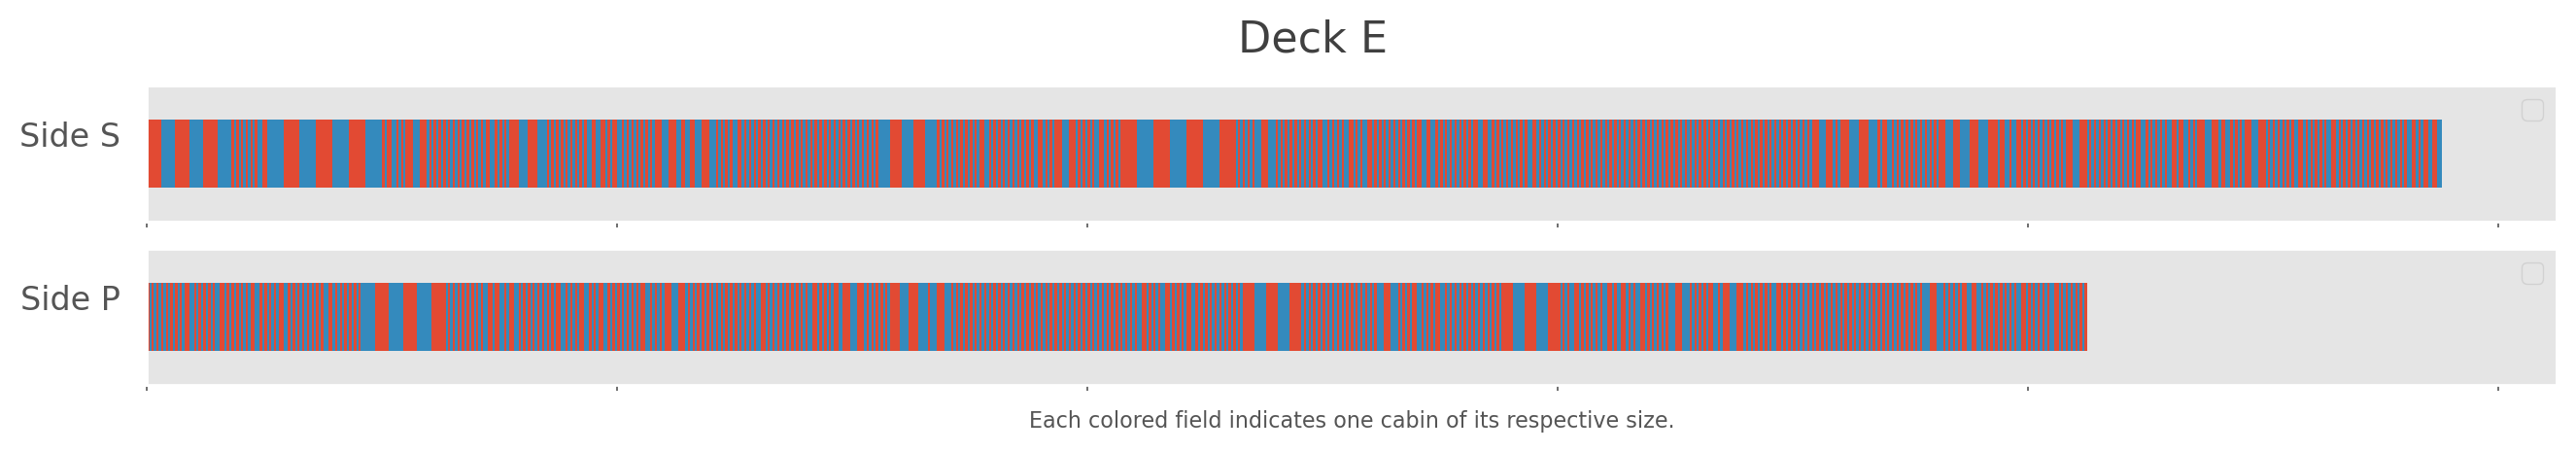

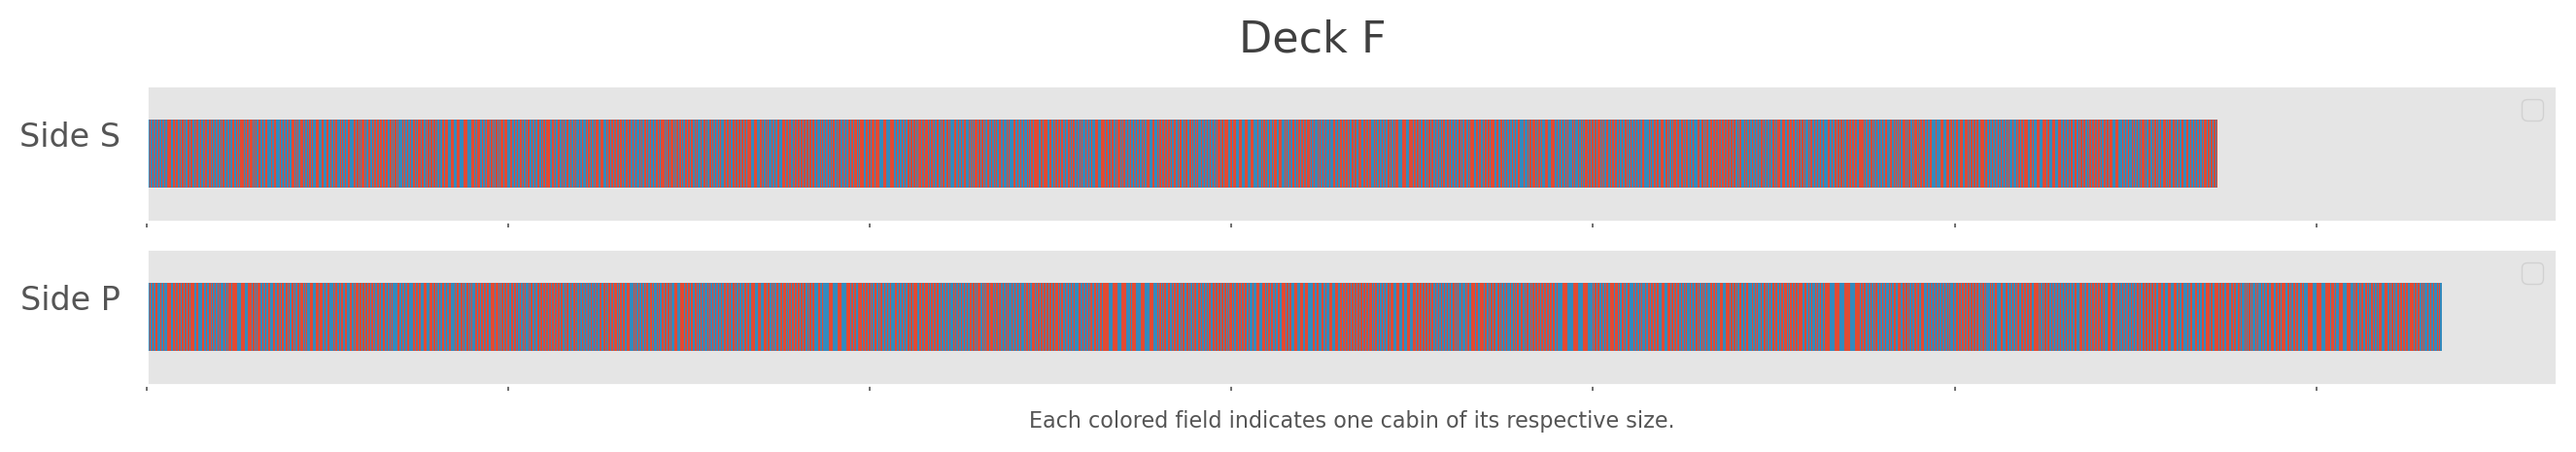

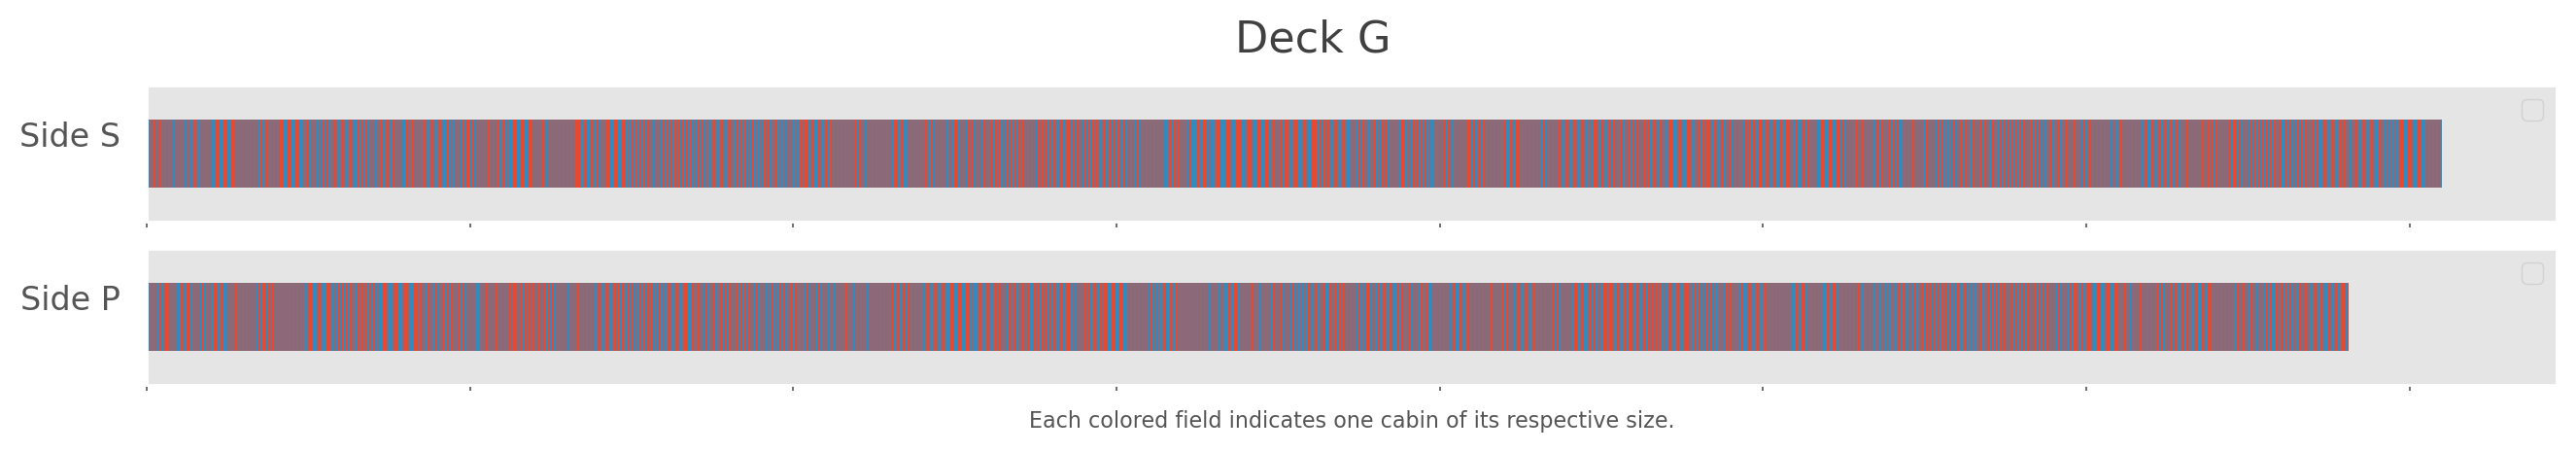

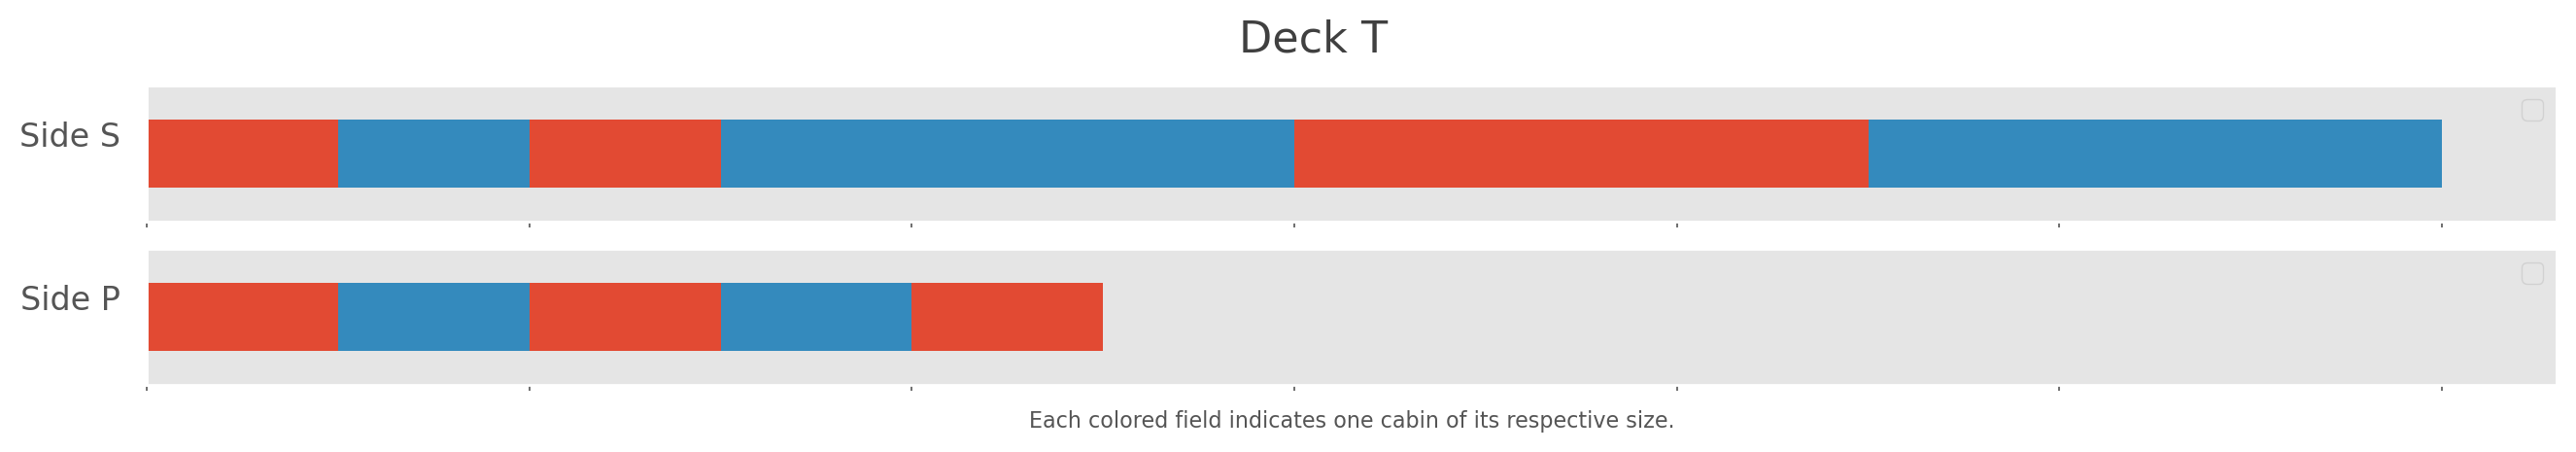

In [33]:
for deck in np.sort(df.cabin_deck.dropna().unique()):
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    df[(df.cabin_deck==deck) & (df.cabin_side=="S")].sort_values("cabin_num")[["cabin_size"]].T.plot.barh(
        stacked=True, color=DEFAULT_COLORS[:2], figsize=(16, 2), ax=ax[0])
    ax[0].legend([])
    ax[0].set_ylabel("Side S", rotation=0, labelpad=25)
    ax[0].set_yticks([])
    df[(df.cabin_deck==deck) & (df.cabin_side=="P")].sort_values("cabin_num")[["cabin_size"]].T.plot.barh(
        stacked=True, color=DEFAULT_COLORS[:2], figsize=(16, 2), ax=ax[1])
    ax[1].legend([])
    ax[1].set_ylabel("Side P", rotation=0, labelpad=25)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_xlabel("Each colored field indicates one cabin of its respective size.", size=8)
    plt.suptitle(f"Deck {deck}", size=16, y=1.05)
    plt.show()

There also don't seem to be any clear patterns present in regard to the effects of the anomaly. Again we can observe that Decks `B` and `C` on side `S` as well as Deck `G` on side `S` were more heavily affected than the rest of the ship.

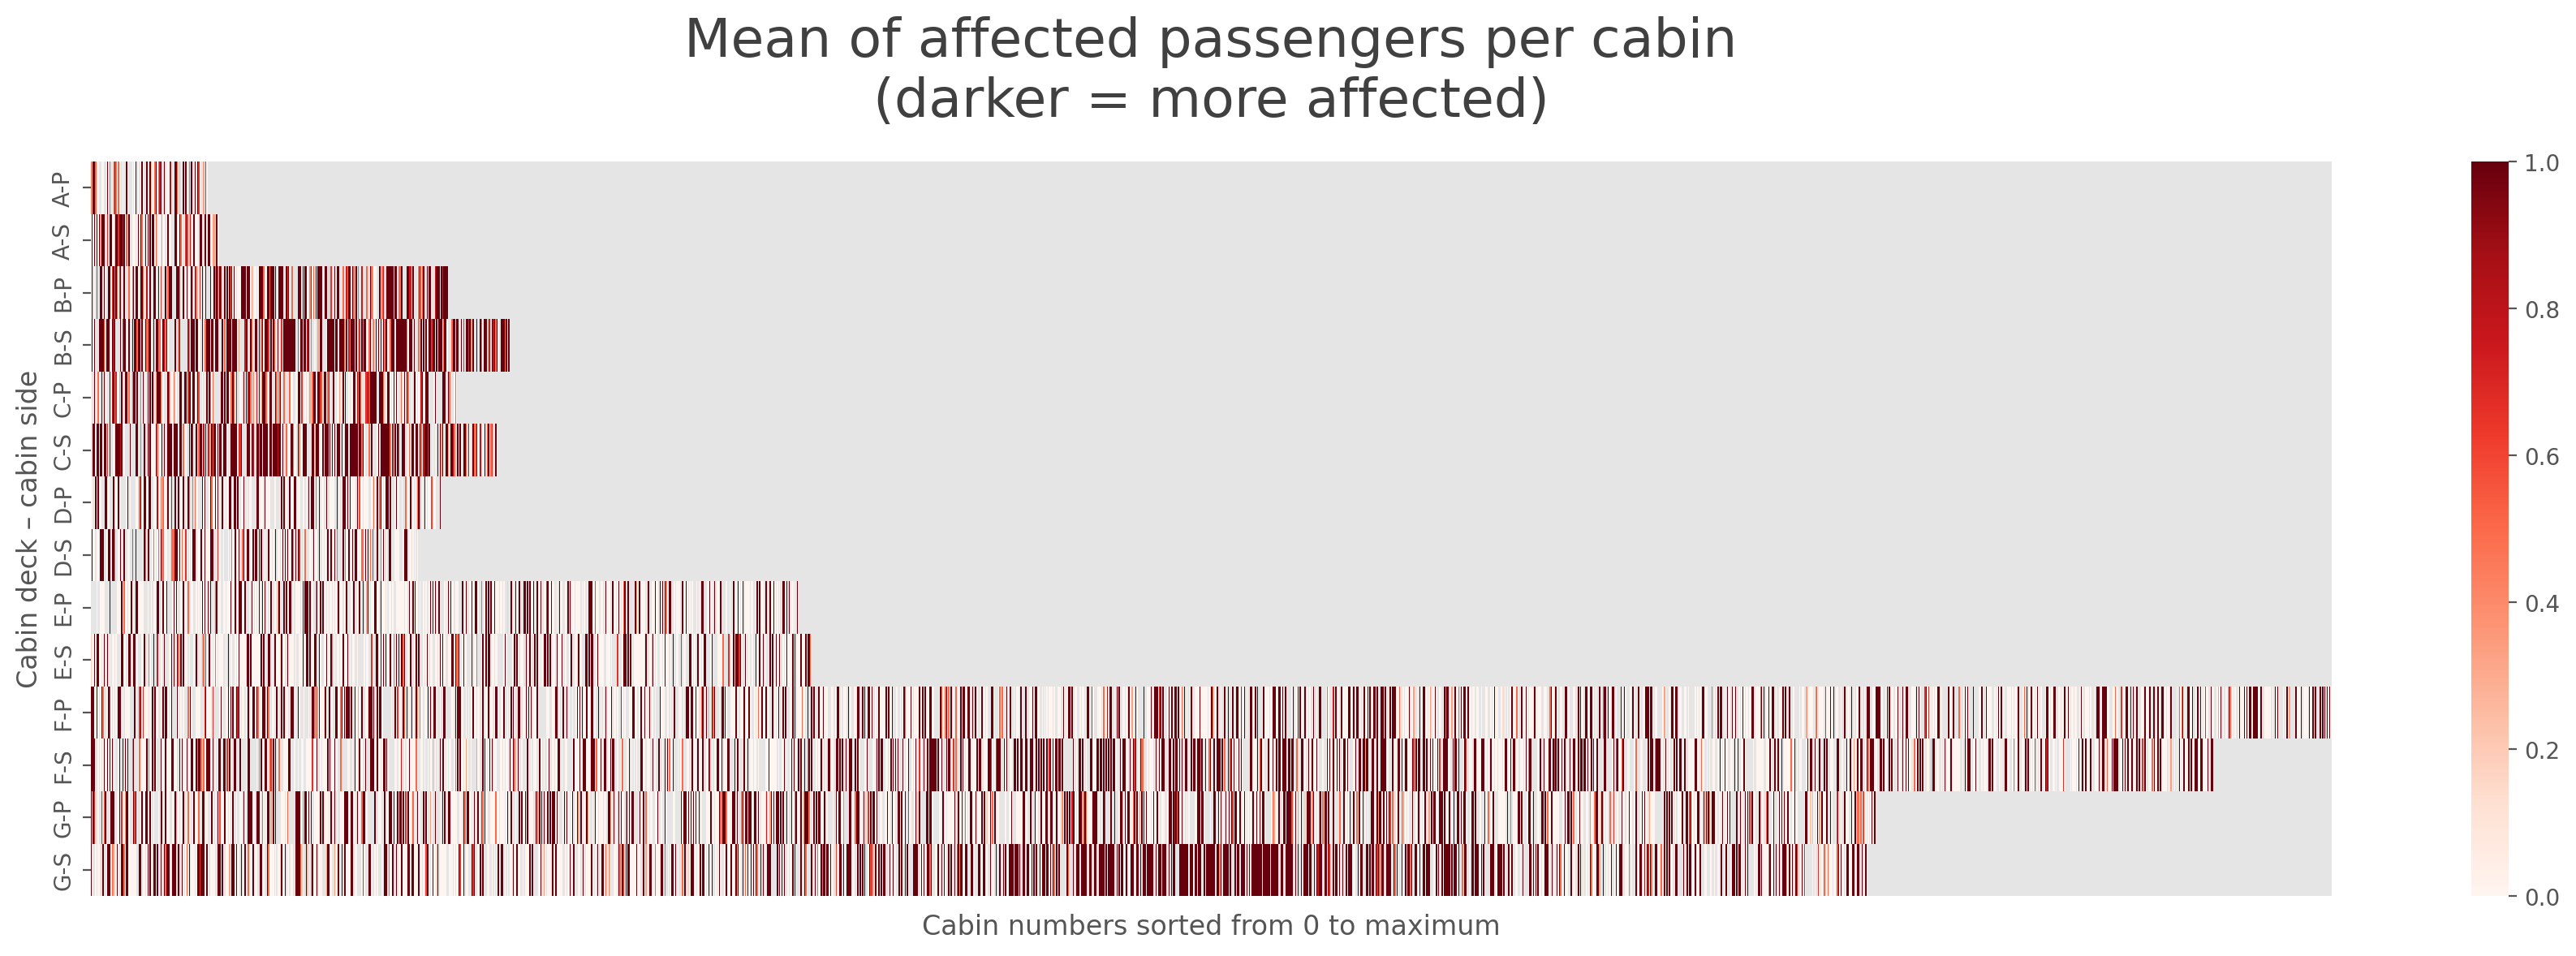

In [34]:
sns.heatmap(df.drop(df[df.cabin_deck=="T"].index).groupby(["cabin_deck", "cabin_side", "cabin_num"]).transported.mean().unstack(), cmap="Reds")
plt.title("Mean of affected passengers per cabin\n(darker = more affected)", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xticks([])
plt.ylabel("Cabin deck – cabin side")
plt.xlabel("Cabin numbers sorted from 0 to maximum")
plt.tight_layout()
plt.show()

- Passengers from decks `A`, `B`, `C` and `T` entirely come from Europa. 
- No passengers from Europa inhabit deck `F` and `G`.
- Passengers on deck `G` all come from Earth.

In [35]:
tmp = df.groupby("cabin_deck").homeplanet.value_counts(normalize=True).to_frame()
print(tmp)

                       homeplanet
cabin_deck homeplanet            
A          Europa        1.000000
B          Europa        1.000000
C          Europa        1.000000
D          Mars          0.578348
           Europa        0.421652
E          Earth         0.452640
           Mars          0.394410
           Europa        0.152950
F          Earth         0.586132
           Mars          0.413868
G          Earth         1.000000
T          Europa        1.000000


No passengers cryosleeping are on deck `T`.

In [36]:
tmp = df.groupby("cabin_deck").cryosleep.value_counts(normalize=True).to_frame()
print(tmp)

                      cryosleep
cabin_deck cryosleep           
A          False       0.703488
           True        0.296512
B          True        0.544883
           False       0.455117
C          False       0.569432
           True        0.430568
D          False       0.760962
           True        0.239038
E          False       0.804954
           True        0.195046
F          False       0.794153
           True        0.205847
G          True        0.546587
           False       0.453413
T          False       1.000000


No VIP passengers inhabit decks `G` and `T`.

In [37]:
tmp = df.groupby("cabin_deck").vip.value_counts(normalize=True).to_frame()
print(tmp)

                       vip
cabin_deck vip            
A          False  0.869186
           True   0.130814
B          False  0.948029
           True   0.051971
C          False  0.948742
           True   0.051258
D          False  0.942008
           True   0.057992
E          False  0.980000
           True   0.020000
F          False  0.990104
           True   0.009896
G          False  1.000000
T          False  1.000000


Again we see that passengers on side starboard were affected more heavily by the anomaly.

In [38]:
def compare_transportation(feature):
    tmp = train.groupby(feature).transported.value_counts(normalize=True).unstack()
    tmp.columns = ["not transported", "transported"]
    print("Percentage of passengers\n")
    print(tabulate(tmp*100, floatfmt=".1f", headers="keys"))
    
compare_transportation("cabin_side")

Percentage of passengers

cabin_side      not transported    transported
------------  -----------------  -------------
P                          54.9           45.1
S                          44.5           55.5


The distribution of the cabin side is almost half/half and similar between train and test set.

In [39]:
def compare_distribution(feature):
    not_in_test = df[df.transported.notna()][feature]
    in_test = df[df.transported.isna()][feature]
    tmp = pd.concat([not_in_test.value_counts(normalize=True).sort_index(), 
                   in_test.value_counts(normalize=True).sort_index()], axis=1)
    tmp.columns = ["train_data", "test_data"]
    print("Percentage of passengers")
    print(tabulate(tmp*100, headers="keys", floatfmt=".1f"))
    
compare_distribution("cabin_side")

Percentage of passengers
      train_data    test_data
--  ------------  -----------
P           49.5         49.9
S           50.5         50.1


#### `homeplanet`

In [40]:
feature = "homeplanet"

- More than half of the passengers come from **Earth**. 
- The rest comes from **[Europa](https://en.wikipedia.org/wiki/Europa_(moon))** (which is one of Jupiter's moons) or **Mars**. 

In [41]:
print("Percentage of passengers")
print(tabulate(df[feature].value_counts(normalize=True).to_frame()*100, floatfmt=".1f"))

Percentage of passengers
------  ----
Earth   54.1
Europa  24.7
Mars    21.2
------  ----


In [42]:
get_missing(feature)

288 missing values for feature «homeplanet» (train: 2.3%, test: 2.0%)


**The anomaly has affected passengers unevenly in regard to their homeplanet.** A lot more travelers from Europa were transported.

In [43]:
compare_transportation(feature)

Percentage of passengers

homeplanet      not transported    transported
------------  -----------------  -------------
Earth                      57.6           42.4
Europa                     34.1           65.9
Mars                       47.7           52.3


The distribution of the feature is similar in the train and the test set.

In [44]:
compare_distribution("homeplanet")

Percentage of passengers
          train_data    test_data
------  ------------  -----------
Earth           54.2         54.0
Europa          25.1         23.9
Mars            20.7         22.1


#### `destination`

All three destination planets actually exist! 😃

- Around 70% of all passengers travel **[TRAPPIST-1e](https://en.wikipedia.org/wiki/TRAPPIST-1e)**. The planet is around 40 lightyears away from Earth and potentially inhabitable.
- Around 21% of the passengers are on their way to **[55 Cancri e](http://www.sci-news.com/astronomy/article00649.html)** which is also around 40 lightyears away. 
- The rest of the passengers – 9.3% – want to travel to **[PSO J318.5-22](https://en.wikipedia.org/wiki/PSO_J318.5%E2%88%9222)** (~80 lightyears away).

In [45]:
feature = "destination"

In [46]:
print(f"Percentage of passengers in regard to {feature}")
print(tabulate(df[feature].value_counts(normalize=True).to_frame()*100, floatfmt=".1f"))

Percentage of passengers in regard to destination
-------------  ----
TRAPPIST-1e    69.9
55 Cancri e    20.8
PSO J318.5-22   9.3
-------------  ----


In [47]:
get_missing("destination")

274 missing values for feature «destination» (train: 2.1%, test: 2.2%)


**The anomaly has affected passengers unevenly in regard to their destination.** Mostly passengers travelling to 55 Cancri e were transported.

In [48]:
compare_transportation(feature)

Percentage of passengers

destination      not transported    transported
-------------  -----------------  -------------
55 Cancri e                 39.0           61.0
PSO J318.5-22               49.6           50.4
TRAPPIST-1e                 52.9           47.1


The distribution of the feature is similar in the train and the test set.

In [49]:
compare_distribution(feature)

Percentage of passengers
                 train_data    test_data
-------------  ------------  -----------
55 Cancri e            21.1         20.1
PSO J318.5-22           9.4          9.3
TRAPPIST-1e            69.5         70.6


#### `cryosleep`

In [50]:
feature = "cryosleep"

In [51]:
get_missing(feature)

310 missing values for feature «cryosleep» (train: 2.5%, test: 2.2%)


More than a third of the passengers have been in cryosleep.

In [52]:
print(f"Percentage of passengers in {feature}")
print(tabulate(df[feature].value_counts(normalize=True).to_frame()*100, floatfmt=".1f"))

Percentage of passengers in cryosleep
-----  ----
False  63.8
True   36.2
-----  ----


More passengers heading for PSO J318.5-22 are in cryosleep than those heading for the other destinations. This makes sense since it is the planet which is farthest away. 

In [53]:
print(tabulate(df.groupby("destination")[feature].value_counts(normalize=True).unstack().sort_values(True, ascending=False)*100, headers="keys", floatfmt=".1f"))

destination      False    True
-------------  -------  ------
PSO J318.5-22     50.3    49.7
55 Cancri e       57.2    42.8
TRAPPIST-1e       67.4    32.6


**Much more cryosleeping passengers were affected by the anomaly.**

In [54]:
compare_transportation(feature)

Percentage of passengers

cryosleep      not transported    transported
-----------  -----------------  -------------
False                     67.1           32.9
True                      18.2           81.8


The distribution is similar in the train and the test set.

In [55]:
compare_distribution(feature)

Percentage of passengers
         train_data    test_data
-----  ------------  -----------
False          64.2         63.1
True           35.8         36.9


#### `vip`

In [56]:
feature = "vip"

In [57]:
get_missing(feature)

296 missing values for feature «vip» (train: 2.3%, test: 2.2%)


Just 2.2% of passengers classify as VIPs.

In [58]:
tmp = df.vip.value_counts(normalize=True).to_frame()
print(f"Percentage of passengers labeled as {feature}")
print(tabulate(tmp*100, floatfmt=".1f"))

Percentage of passengers labeled as vip
-----  ----
False  97.8
True    2.2
-----  ----


VIP passengers are mainly older than non VIP passengers.

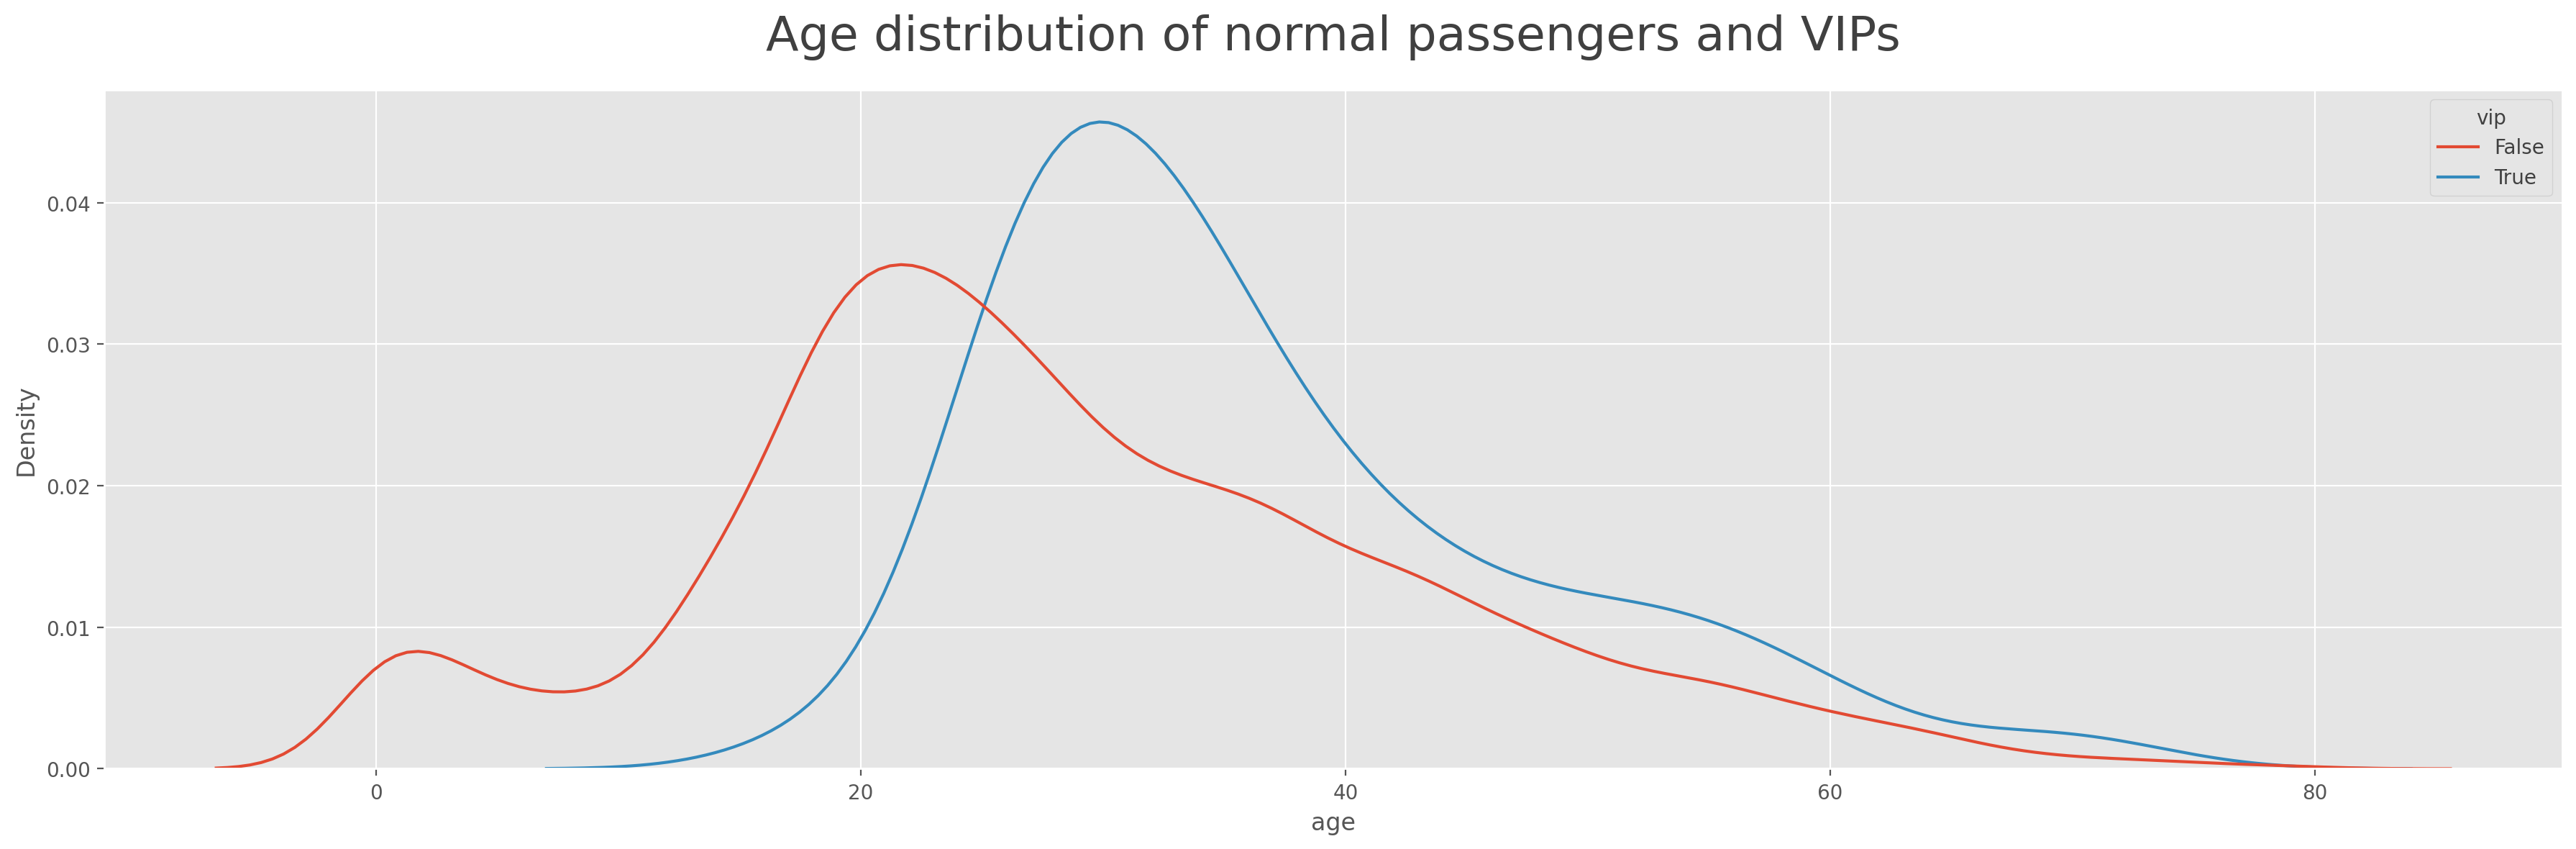

In [59]:
sns.kdeplot(data=df, x="age", hue="vip", common_norm=False, palette=DEFAULT_COLORS[:2])
plt.title("Age distribution of normal passengers and VIPs", size=TITLE_SIZE, pad=TITLE_PAD)
plt.tight_layout()
plt.show()

**The anomaly has affected the VIPs less than the non VIPs.**

In [60]:
compare_transportation(feature)

Percentage of passengers

vip      not transported    transported
-----  -----------------  -------------
False               49.4           50.6
True                61.8           38.2


The test data has a little less VIPs than the train data.

In [61]:
compare_distribution(feature)

Percentage of passengers
         train_data    test_data
-----  ------------  -----------
False          97.7         98.2
True            2.3          1.8


#### `age`

In [62]:
feature = "age"

In [63]:
get_missing(feature)

270 missing values for feature «age» (train: 2.1%, test: 2.1%)


Passenger ages range from 0 to 79 years. The average age is 28.8 with a median of 27. 

In [64]:
display(df.age.describe().to_frame().style.format("{:.1f}"))

,age
count,12700.0
mean,28.8
std,14.4
min,0.0
25%,19.0
50%,27.0
75%,38.0
max,79.0


We have some outliers for `age`.

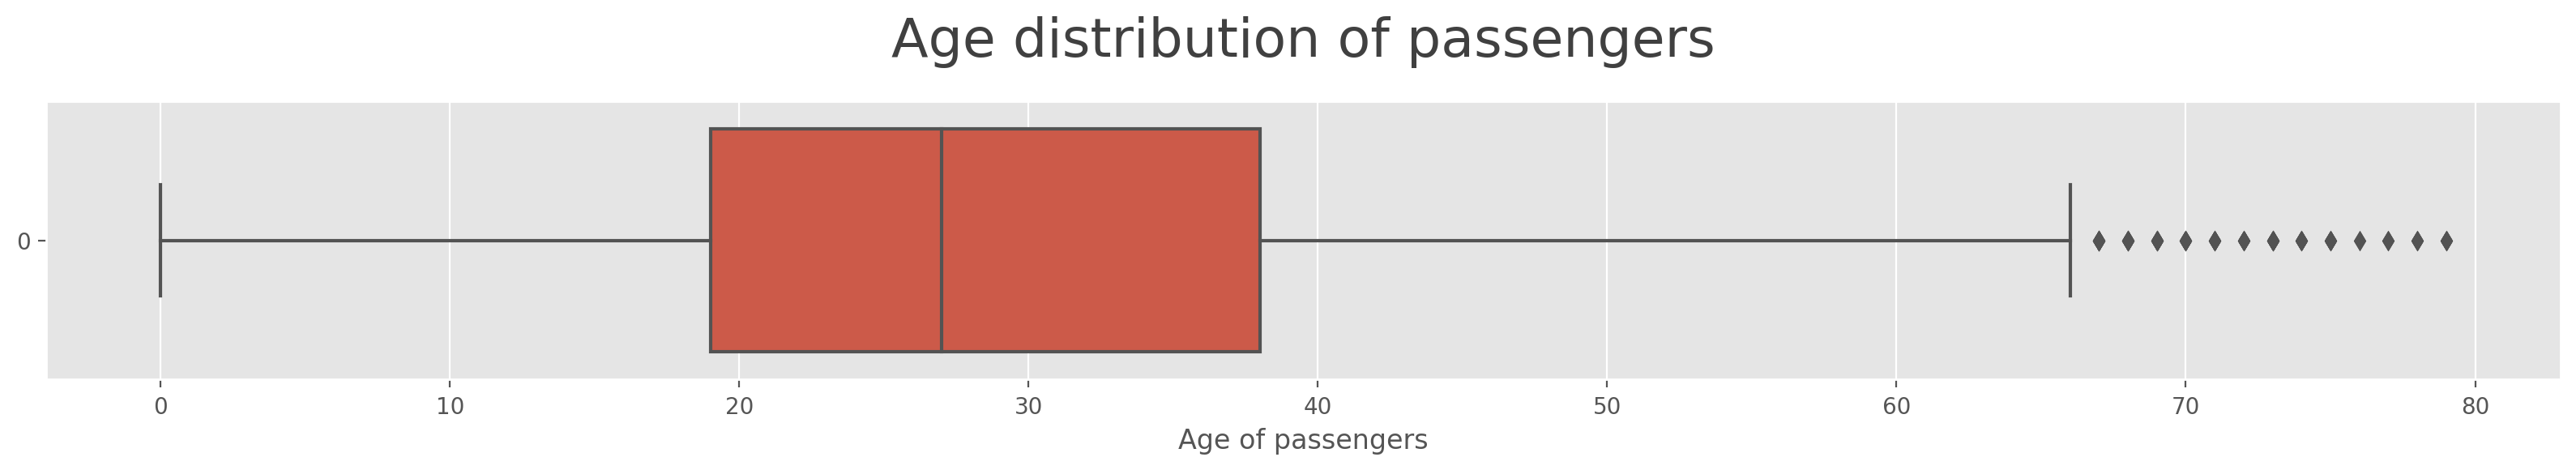

In [65]:
plt.figure(figsize=(16,3))
sns.boxplot(data=df.age, orient="horizontal")
plt.title("Age distribution of passengers", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlabel("Age of passengers")
plt.tight_layout()
plt.show()

Feature `age` is not normally distributed. There seem to be quite a few young children on board and a long tail of older passengers.

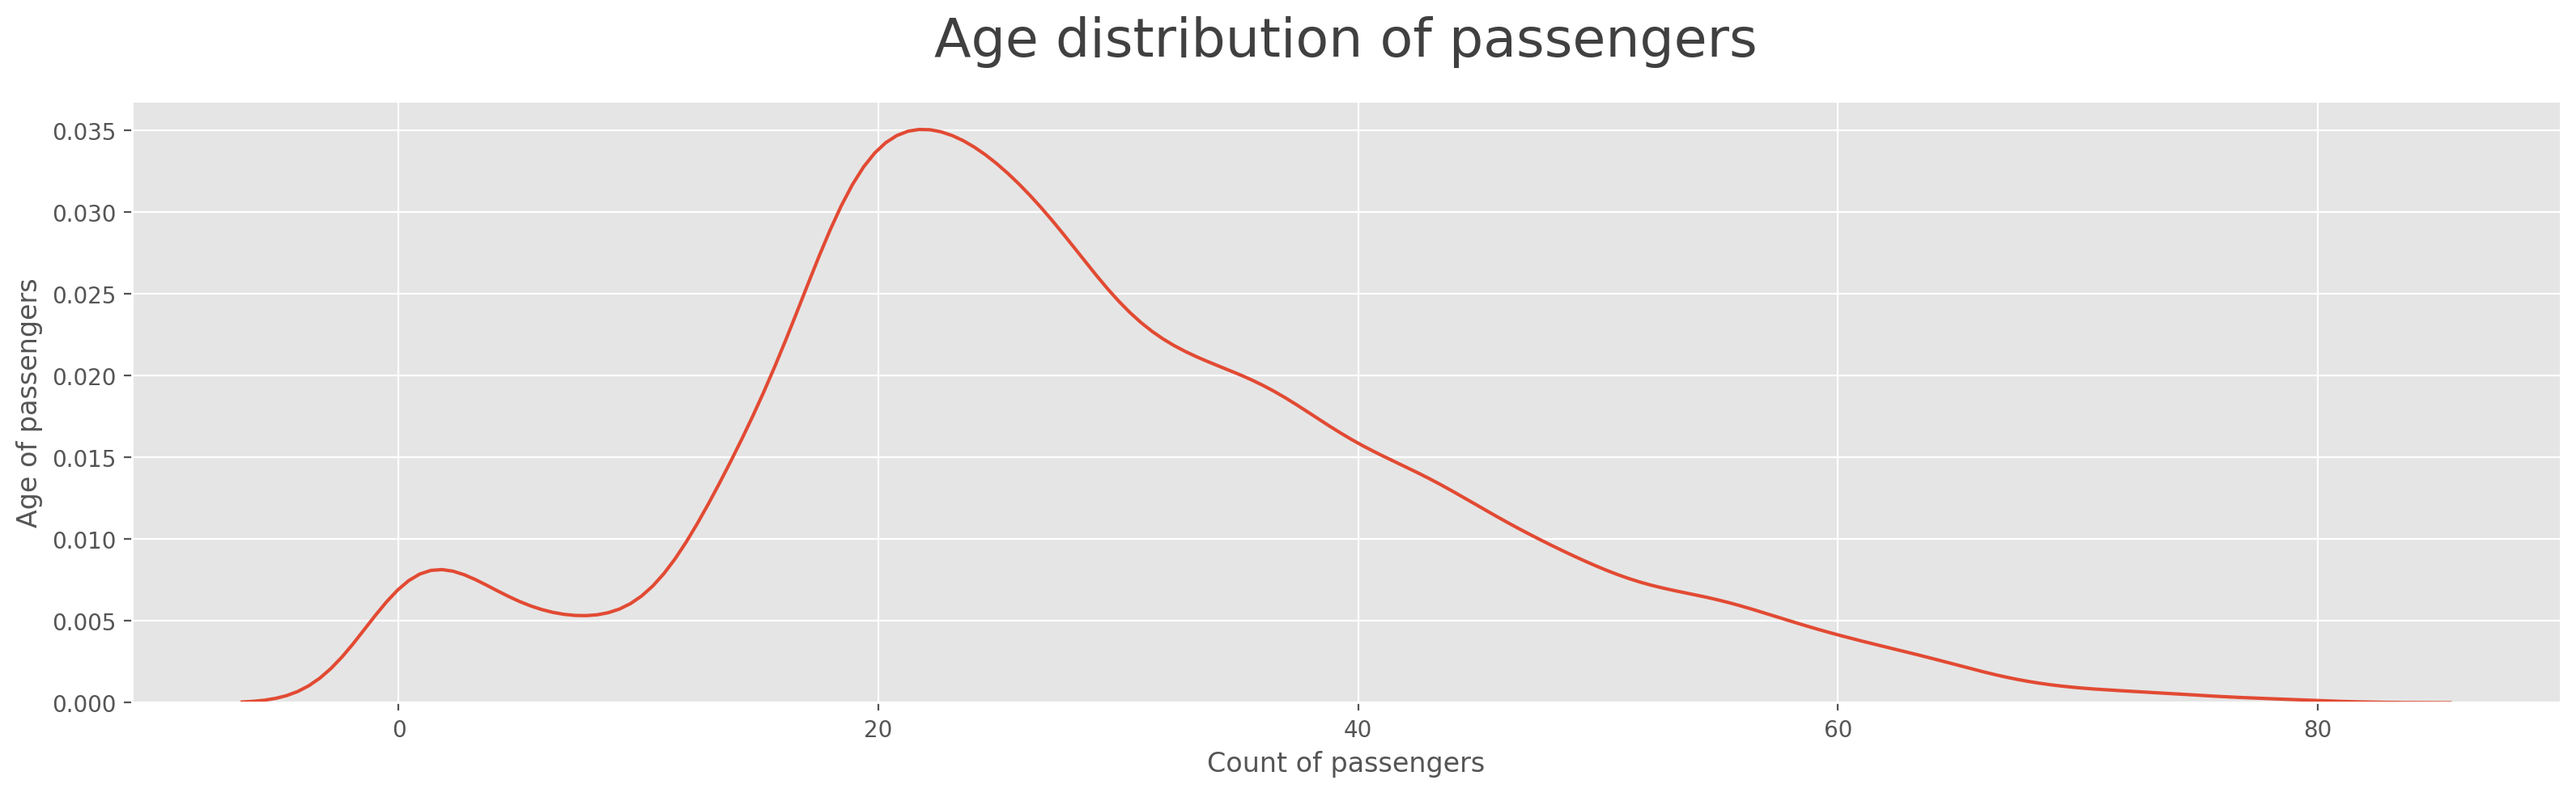

In [66]:
plt.figure(figsize=(16,5))
sns.kdeplot(df.age, color=DEFAULT_COLORS[0])
plt.title("Age distribution of passengers", size=TITLE_SIZE, pad=TITLE_PAD)
plt.ylabel("Age of passengers")
plt.xlabel("Count of passengers")
plt.tight_layout()
plt.show()

The anomaly has affected particularly younger passengers.

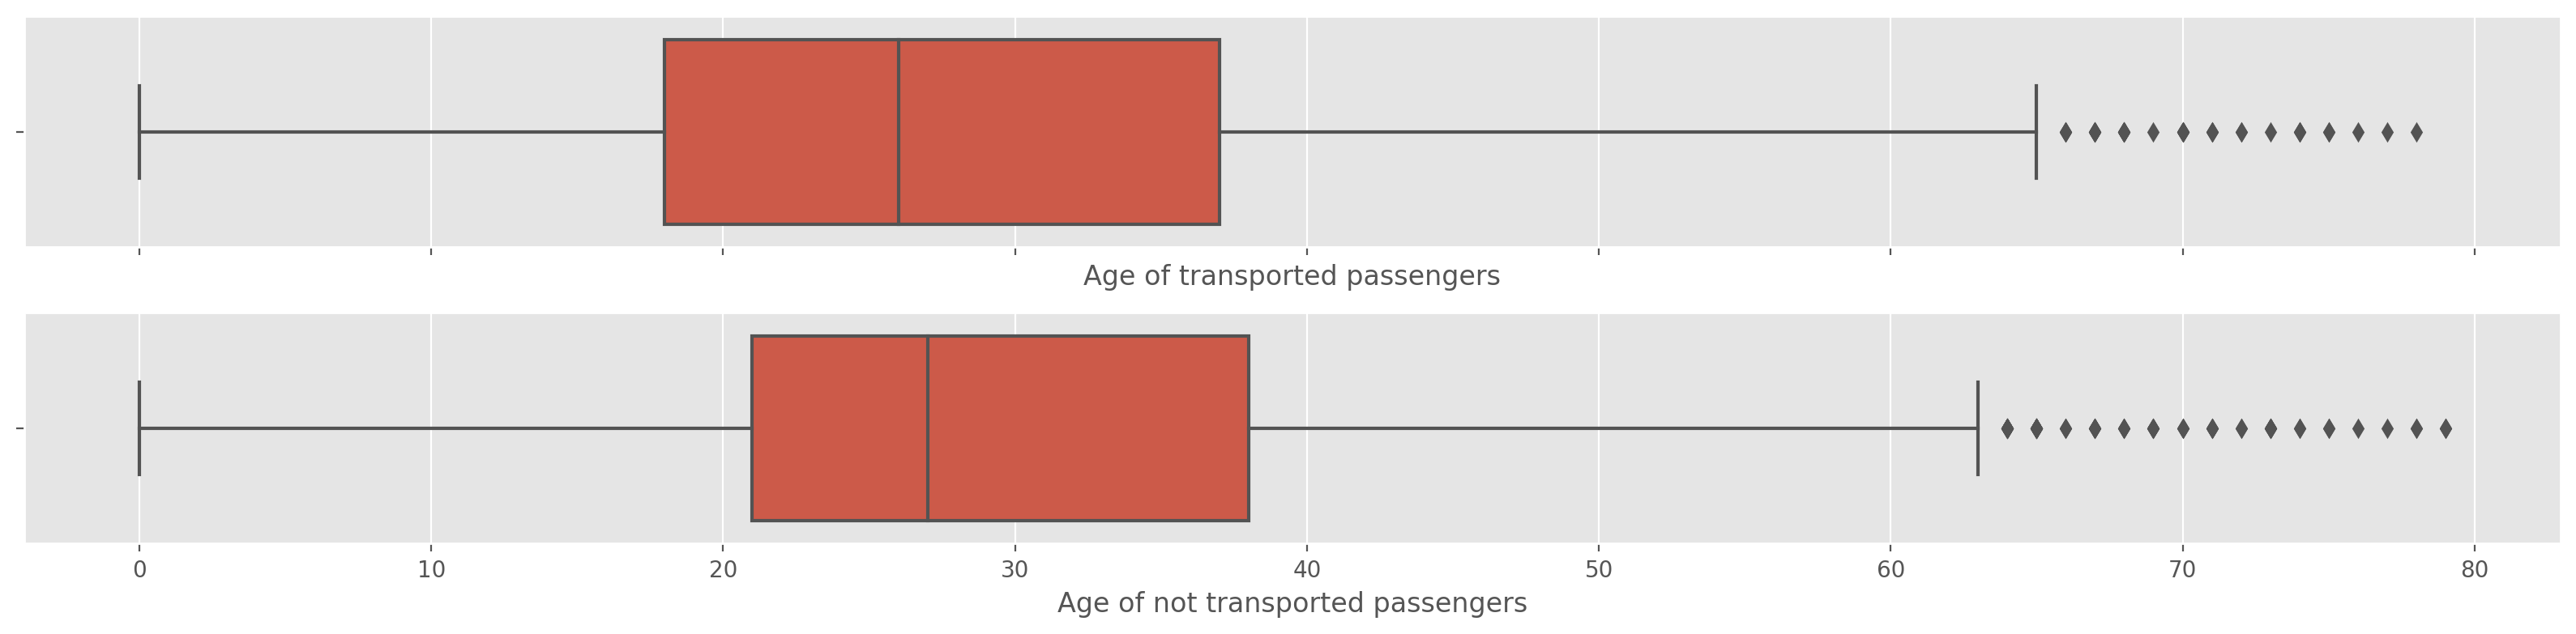

In [67]:
fig, ax = plt.subplots(nrows=2, figsize=(16,4), sharex=True)
sns.boxplot(data=df[df.transported==True], x="age", orient="horizontal", ax=ax[0])
ax[0].set_xlabel("Age of transported passengers")
sns.boxplot(data=df[df.transported==False], x="age", orient="horizontal", ax=ax[1])
ax[1].set_xlabel("Age of not transported passengers")
plt.tight_layout()
plt.show()

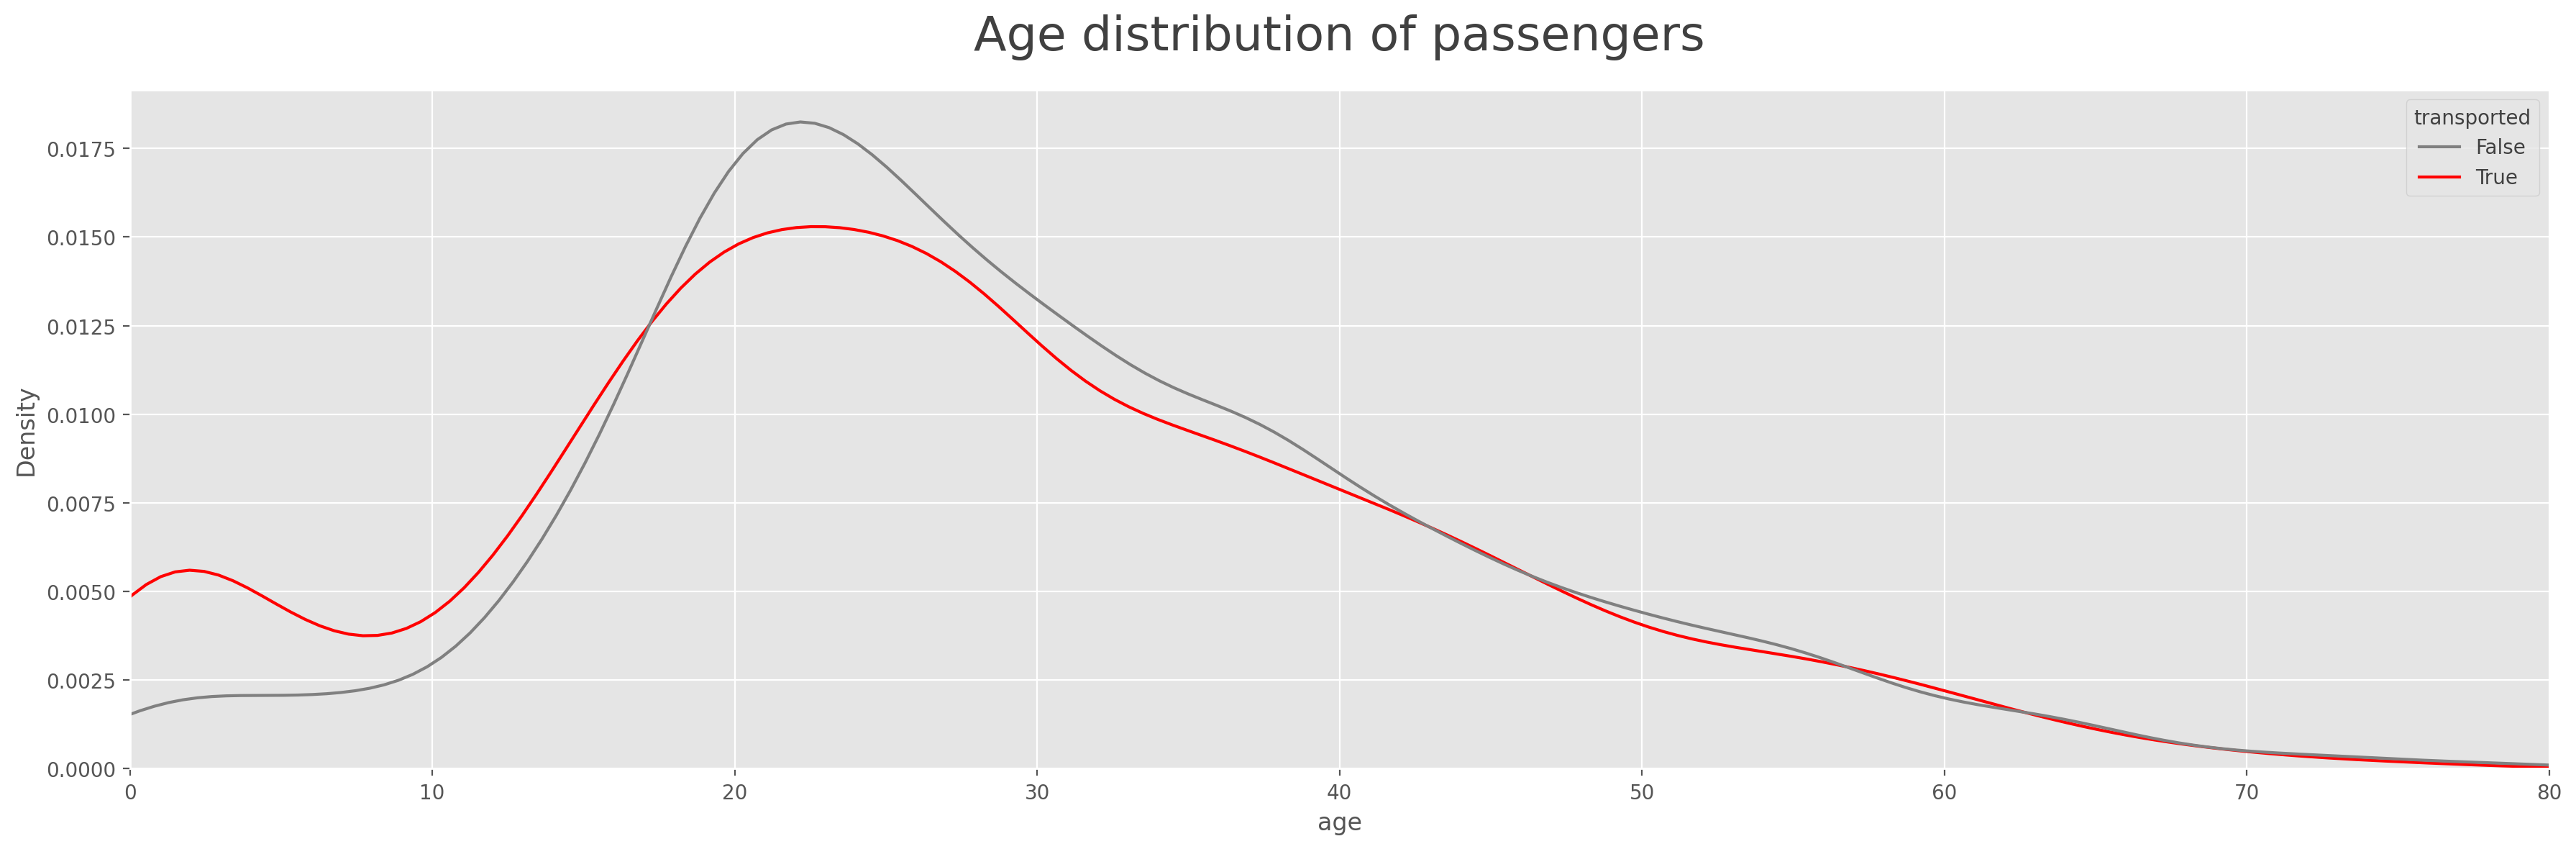

In [68]:
sns.kdeplot(data=df, x="age", hue="transported", palette=["grey", "red"])
plt.title("Age distribution of passengers", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlim(0, 80)
plt.tight_layout()
plt.show()

By binning in age groups we observe the same phenomenon: Younger passengers were affected more heavily by the anomaly while the oldest passengers were affected less so.

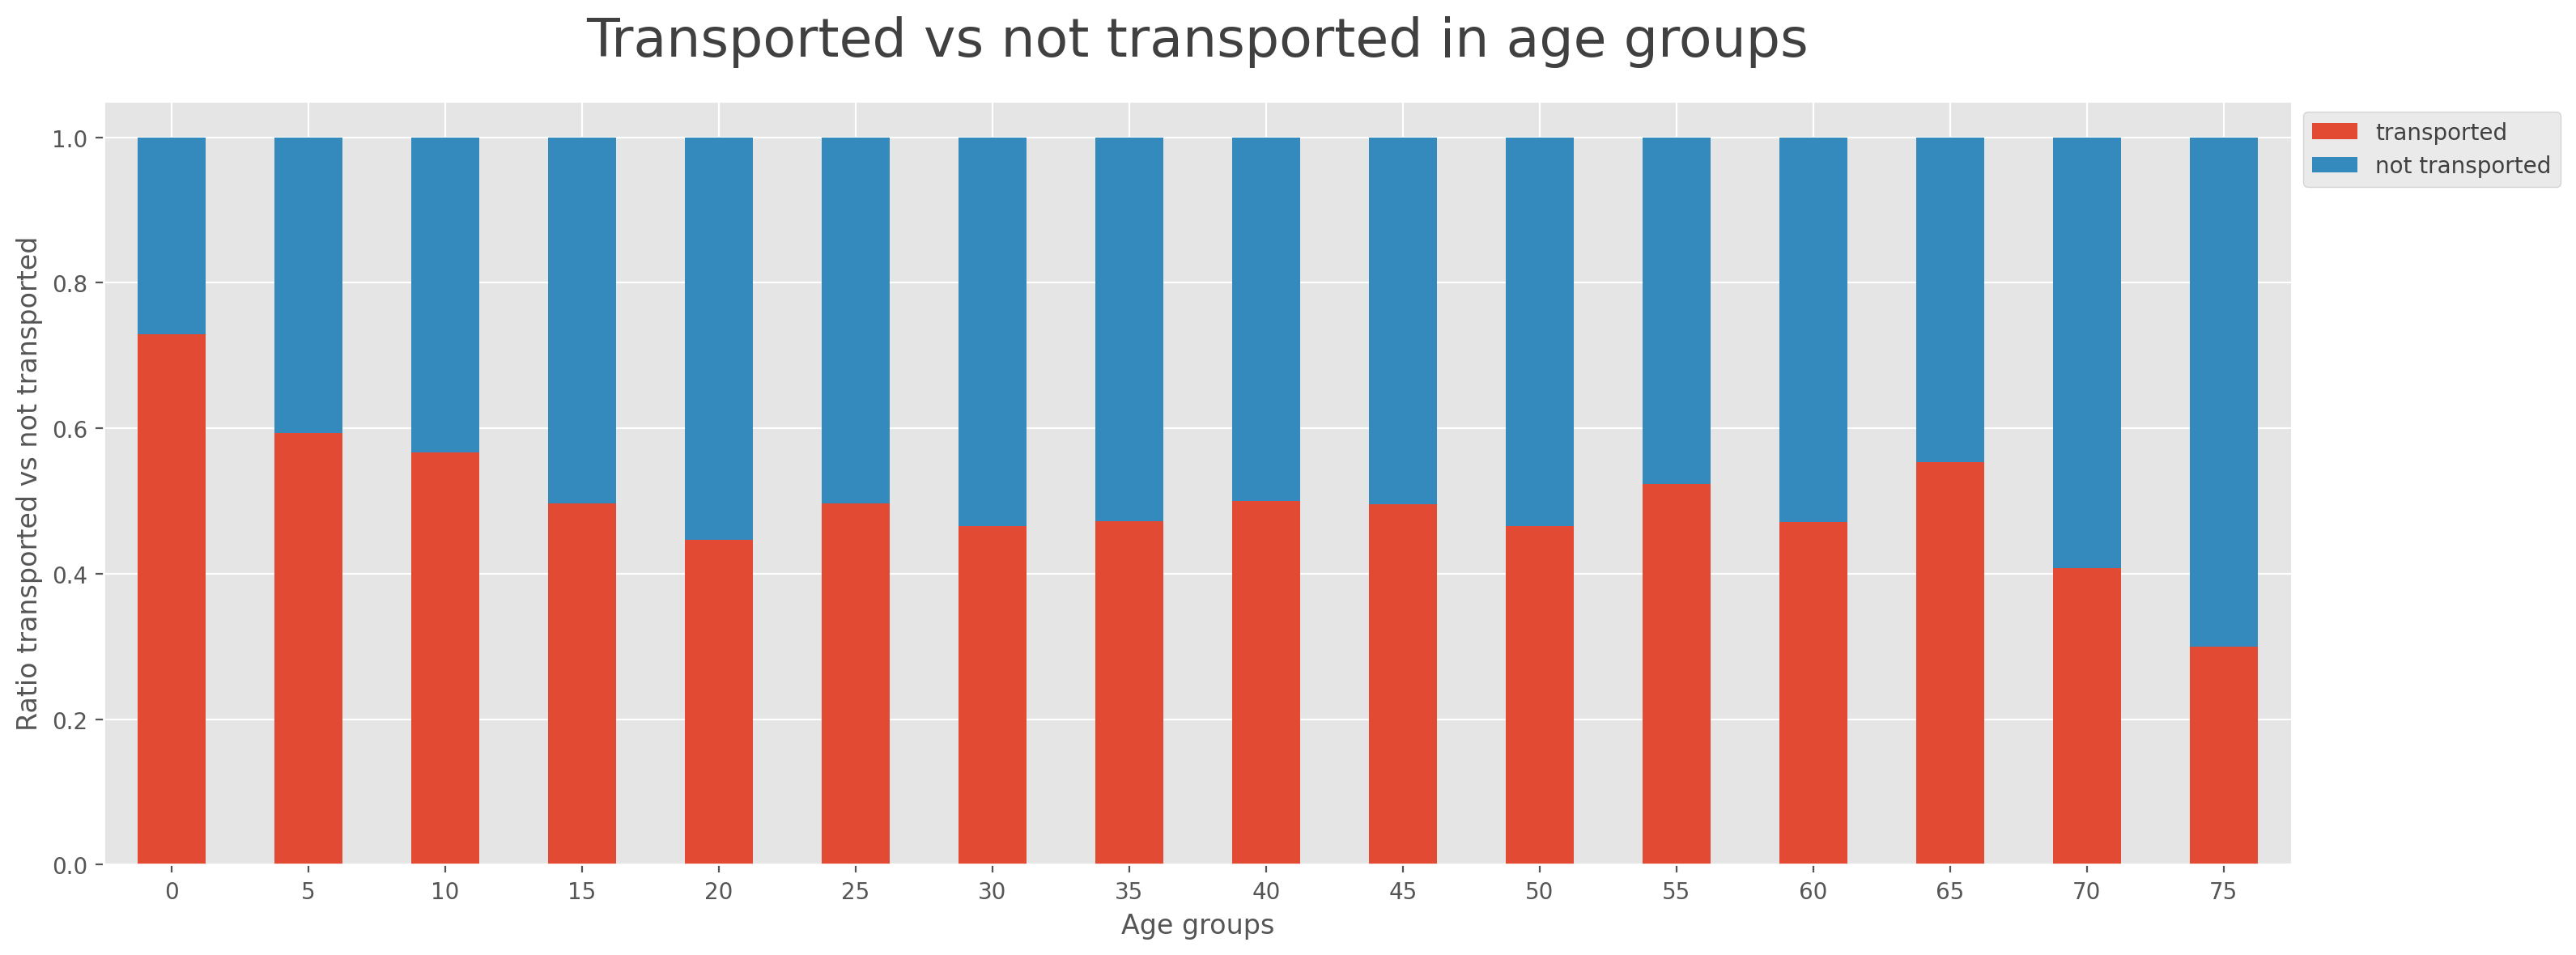

In [69]:
tmp = df.groupby("age_bins").transported.value_counts(normalize=True).unstack()
tmp = tmp.iloc[:, ::-1]

tmp.plot.bar(stacked=True, figsize=(16,6))
plt.title("Transported vs not transported in age groups", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xticks(rotation=0)
plt.ylabel("Ratio transported vs not transported")
plt.xlabel("Age groups")
plt.legend(["transported", "not transported"], bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

Passengers from Earth are younger than those form Mars and Europa.

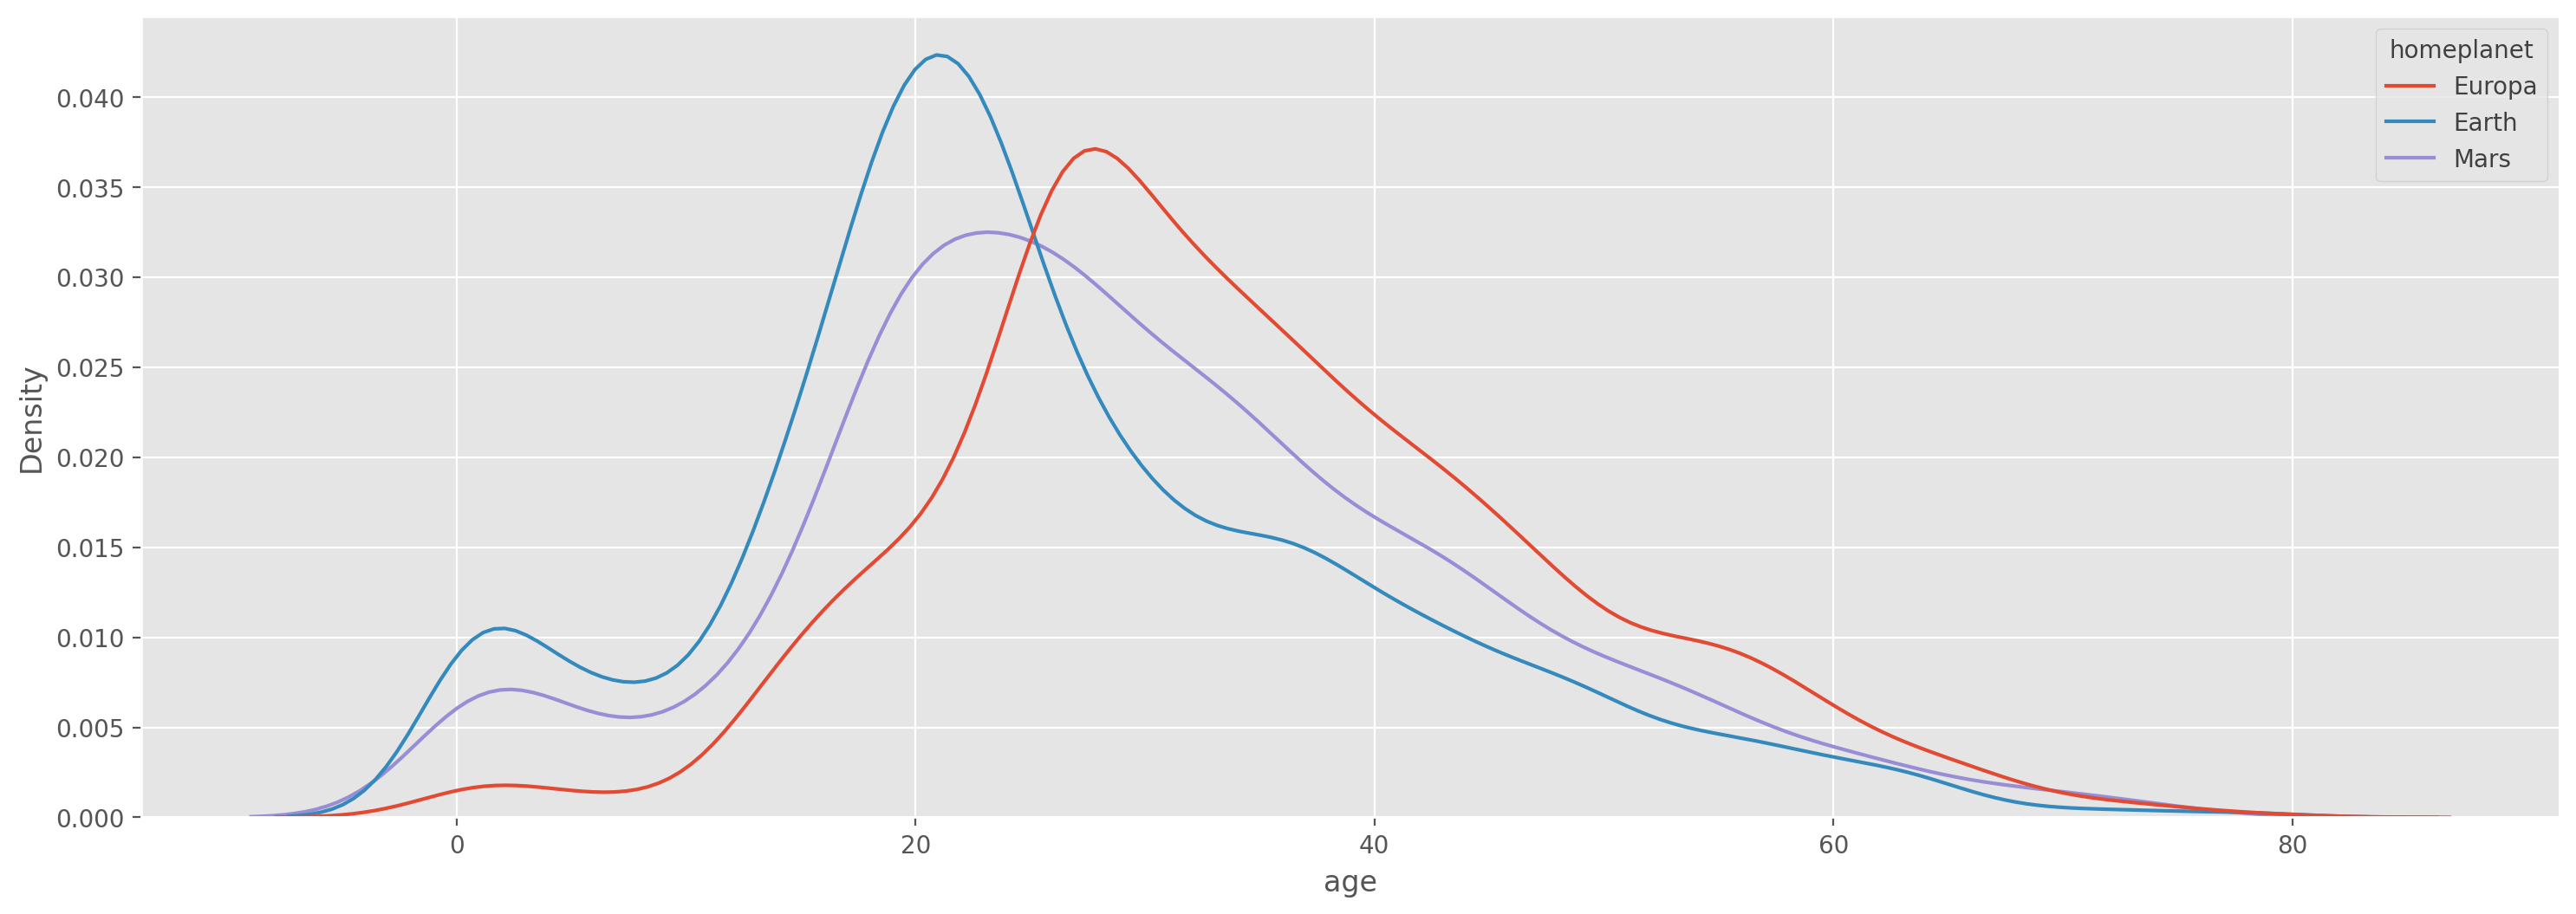

In [70]:
sns.kdeplot(data=df, x="age", hue="homeplanet", 
            common_norm=False, 
            palette=DEFAULT_COLORS[:3])
plt.show()

The distribution of `age` is similar between train and test data.

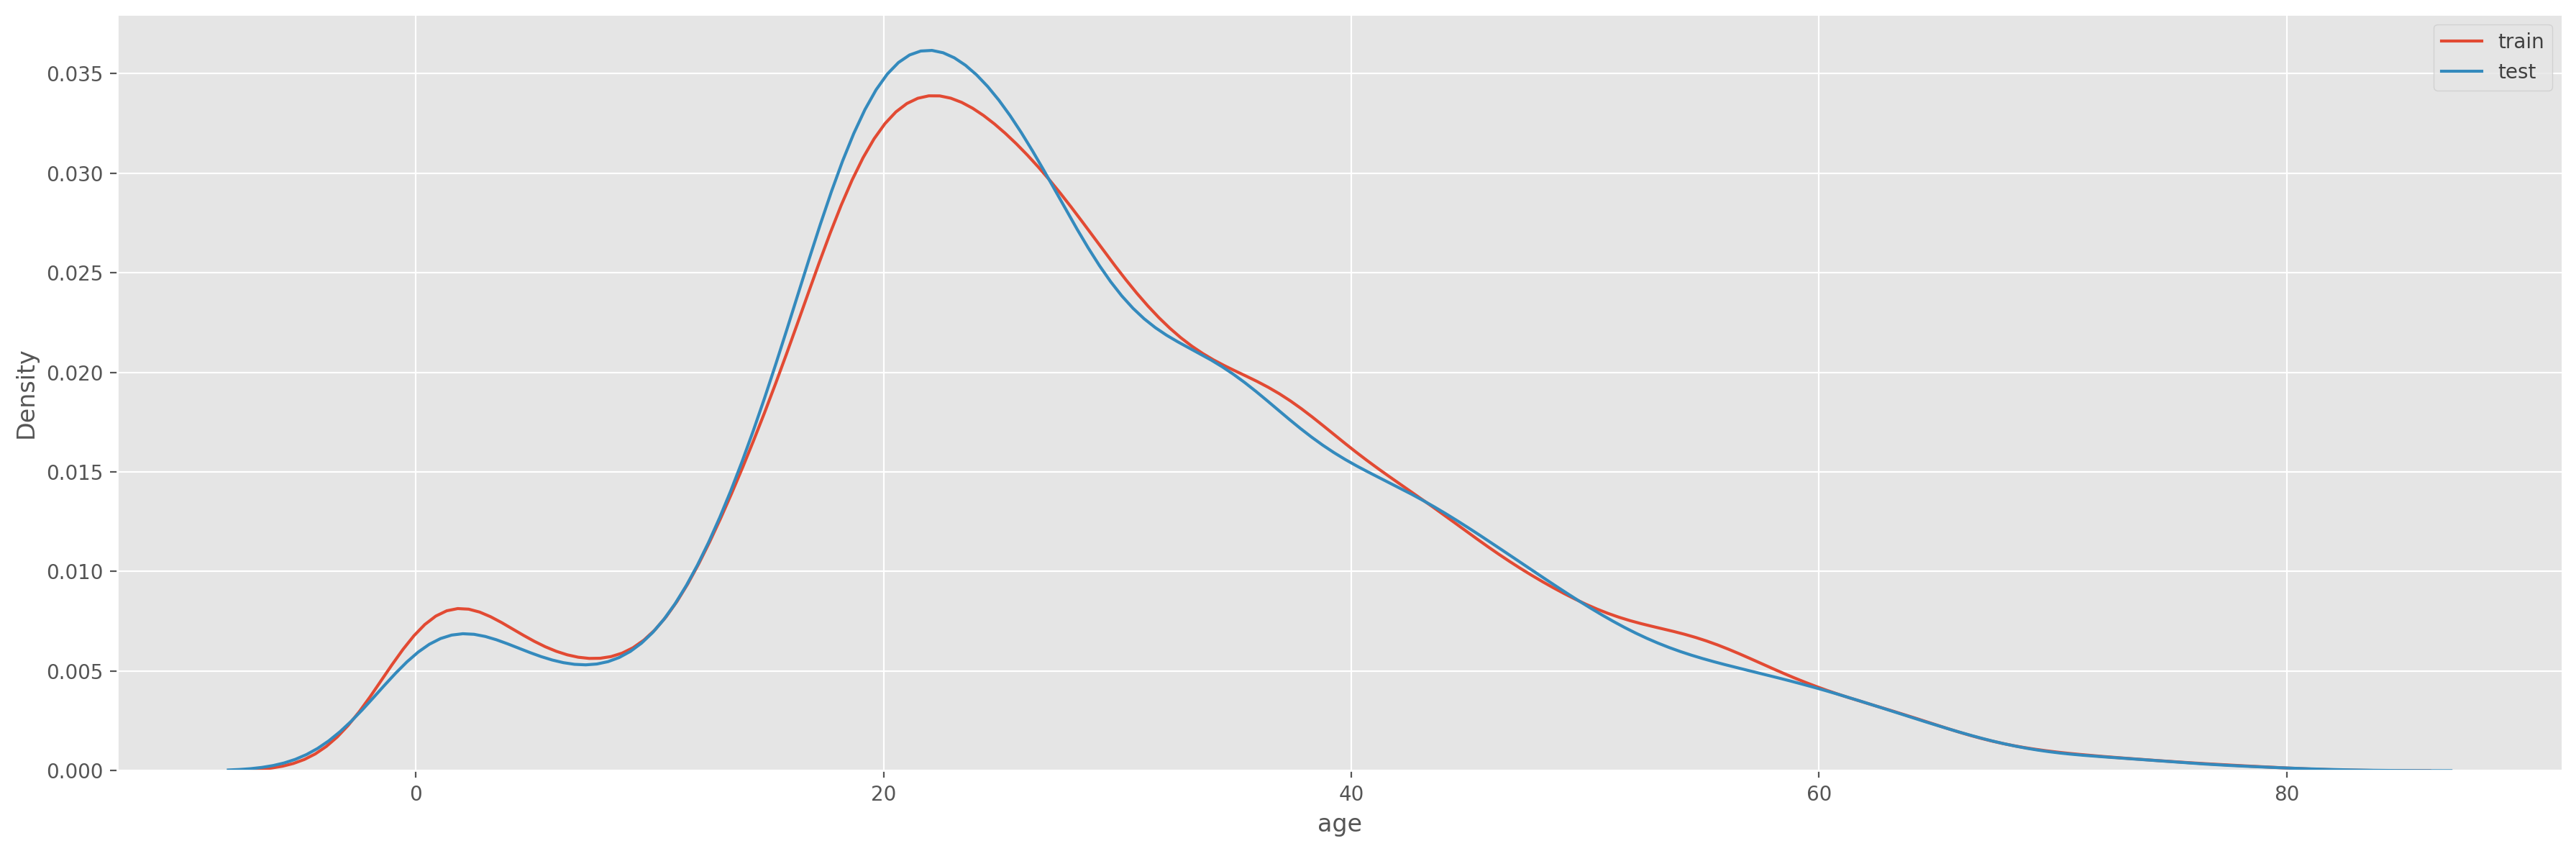

In [71]:
sns.kdeplot(data=train, x="age", common_norm=False, color=DEFAULT_COLORS[0])
sns.kdeplot(data=test, x="age", common_norm=False, color=DEFAULT_COLORS[1])
plt.legend(["train", "test"])
plt.tight_layout()
plt.show()

#### Expenses

In [72]:
for feature in expenses:
    get_missing(feature)

263 missing values for feature «roomservice» (train: 2.1%, test: 1.9%)
289 missing values for feature «foodcourt» (train: 2.1%, test: 2.5%)
306 missing values for feature «shoppingmall» (train: 2.4%, test: 2.3%)
284 missing values for feature «spa» (train: 2.1%, test: 2.4%)
268 missing values for feature «vrdeck» (train: 2.2%, test: 1.9%)


The distribution of expenses is quite similar to each other. However, the values aren't normally distributed but rather skewed.

In [73]:
results = []
for expense in expenses:
    results.append(df[expense].describe())
tmp = pd.concat(results, axis=1)
print(tabulate(tmp, headers="keys", floatfmt=",.0f"))

         roomservice    foodcourt    shoppingmall     spa    vrdeck
-----  -------------  -----------  --------------  ------  --------
count         12,707       12,681          12,664  12,686    12,702
mean             223          452             175     308       307
std              648        1,584             591   1,130     1,180
min                0            0               0       0         0
25%                0            0               0       0         0
50%                0            0               0       0         0
75%               49           77              29      57        42
max           14,327       29,813          23,492  22,408    24,133


Passengers have spent most of their money for food and the least amount in the shopping mall.

In [74]:
print(tabulate(df[expenses].sum().sort_values(ascending=False).to_frame(), floatfmt=",.0f"))

------------  ---------
foodcourt     5,731,326
spa           3,913,338
vrdeck        3,896,840
roomservice   2,832,363
shoppingmall  2,215,010
------------  ---------


The distributions of spendings in the various categories appear similar (all samples with a value of zero removed).

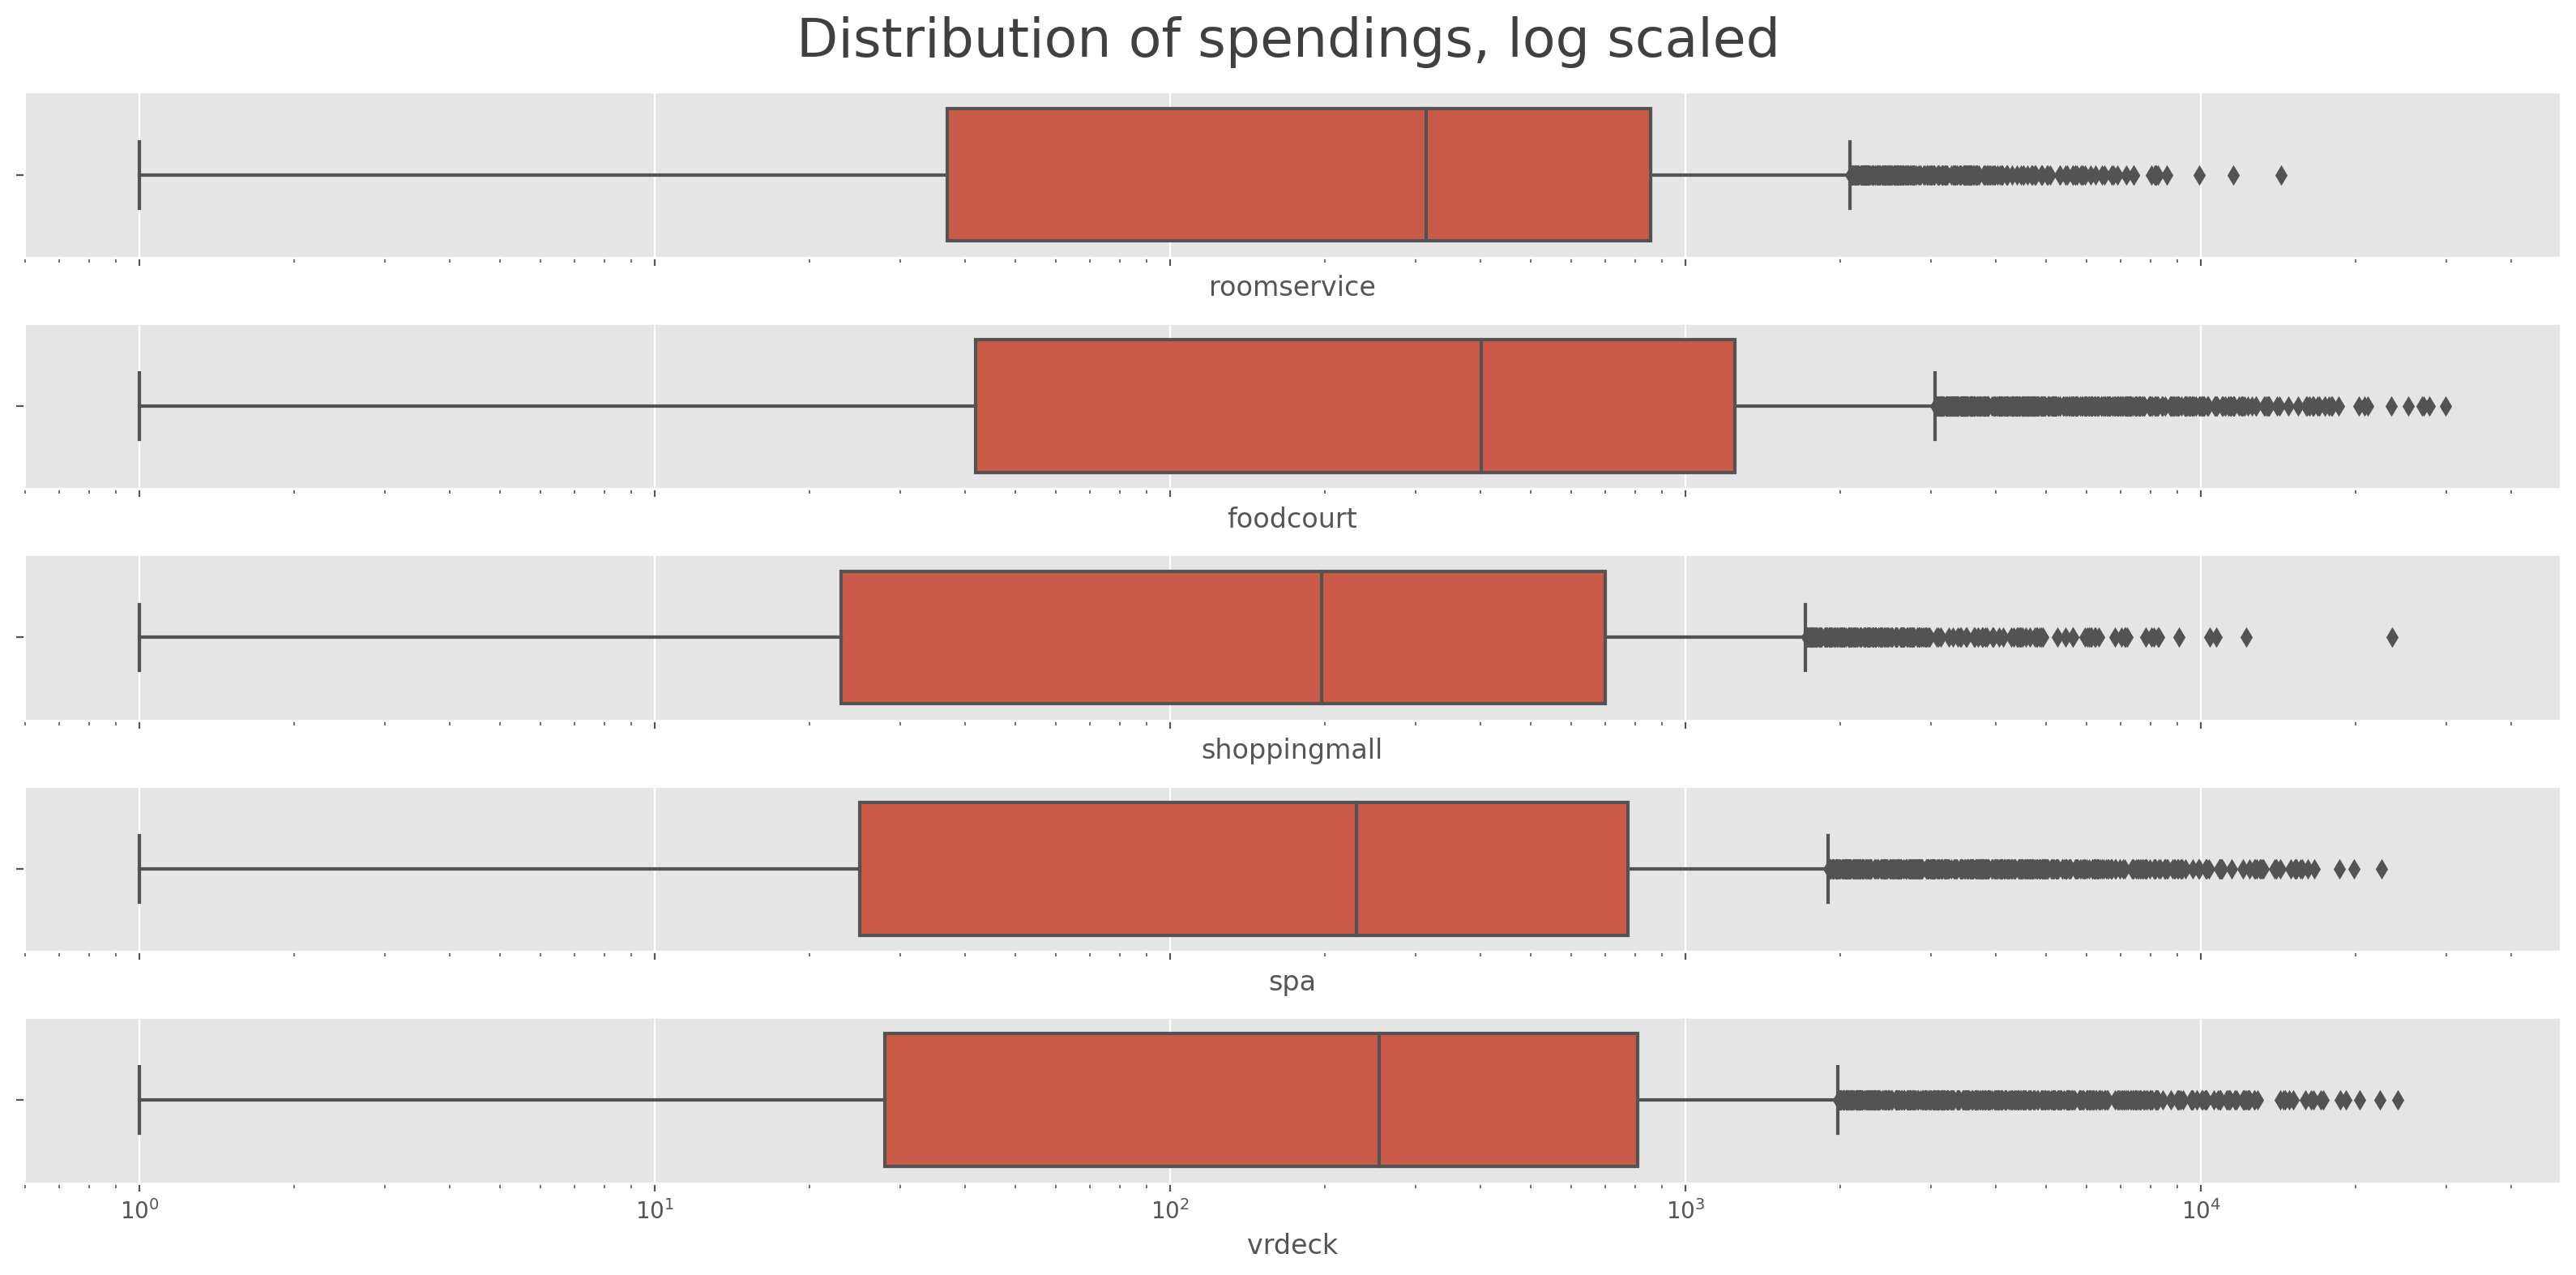

In [75]:
fig, ax = plt.subplots(nrows=len(expenses), sharex=True, figsize=(16, 8))

for idx, expense in enumerate(expenses):
    tmp = df[df[expense]>0]
    sns.boxplot(data=tmp, x=expense, ax=ax[idx], color=DEFAULT_COLORS[0])
plt.suptitle("Distribution of spendings, log scaled", size=TITLE_SIZE)
plt.xscale('log') 
plt.tight_layout()
plt.show()

From age 15 onward the distribution of total spendings is quite similar without any obvious pattern.

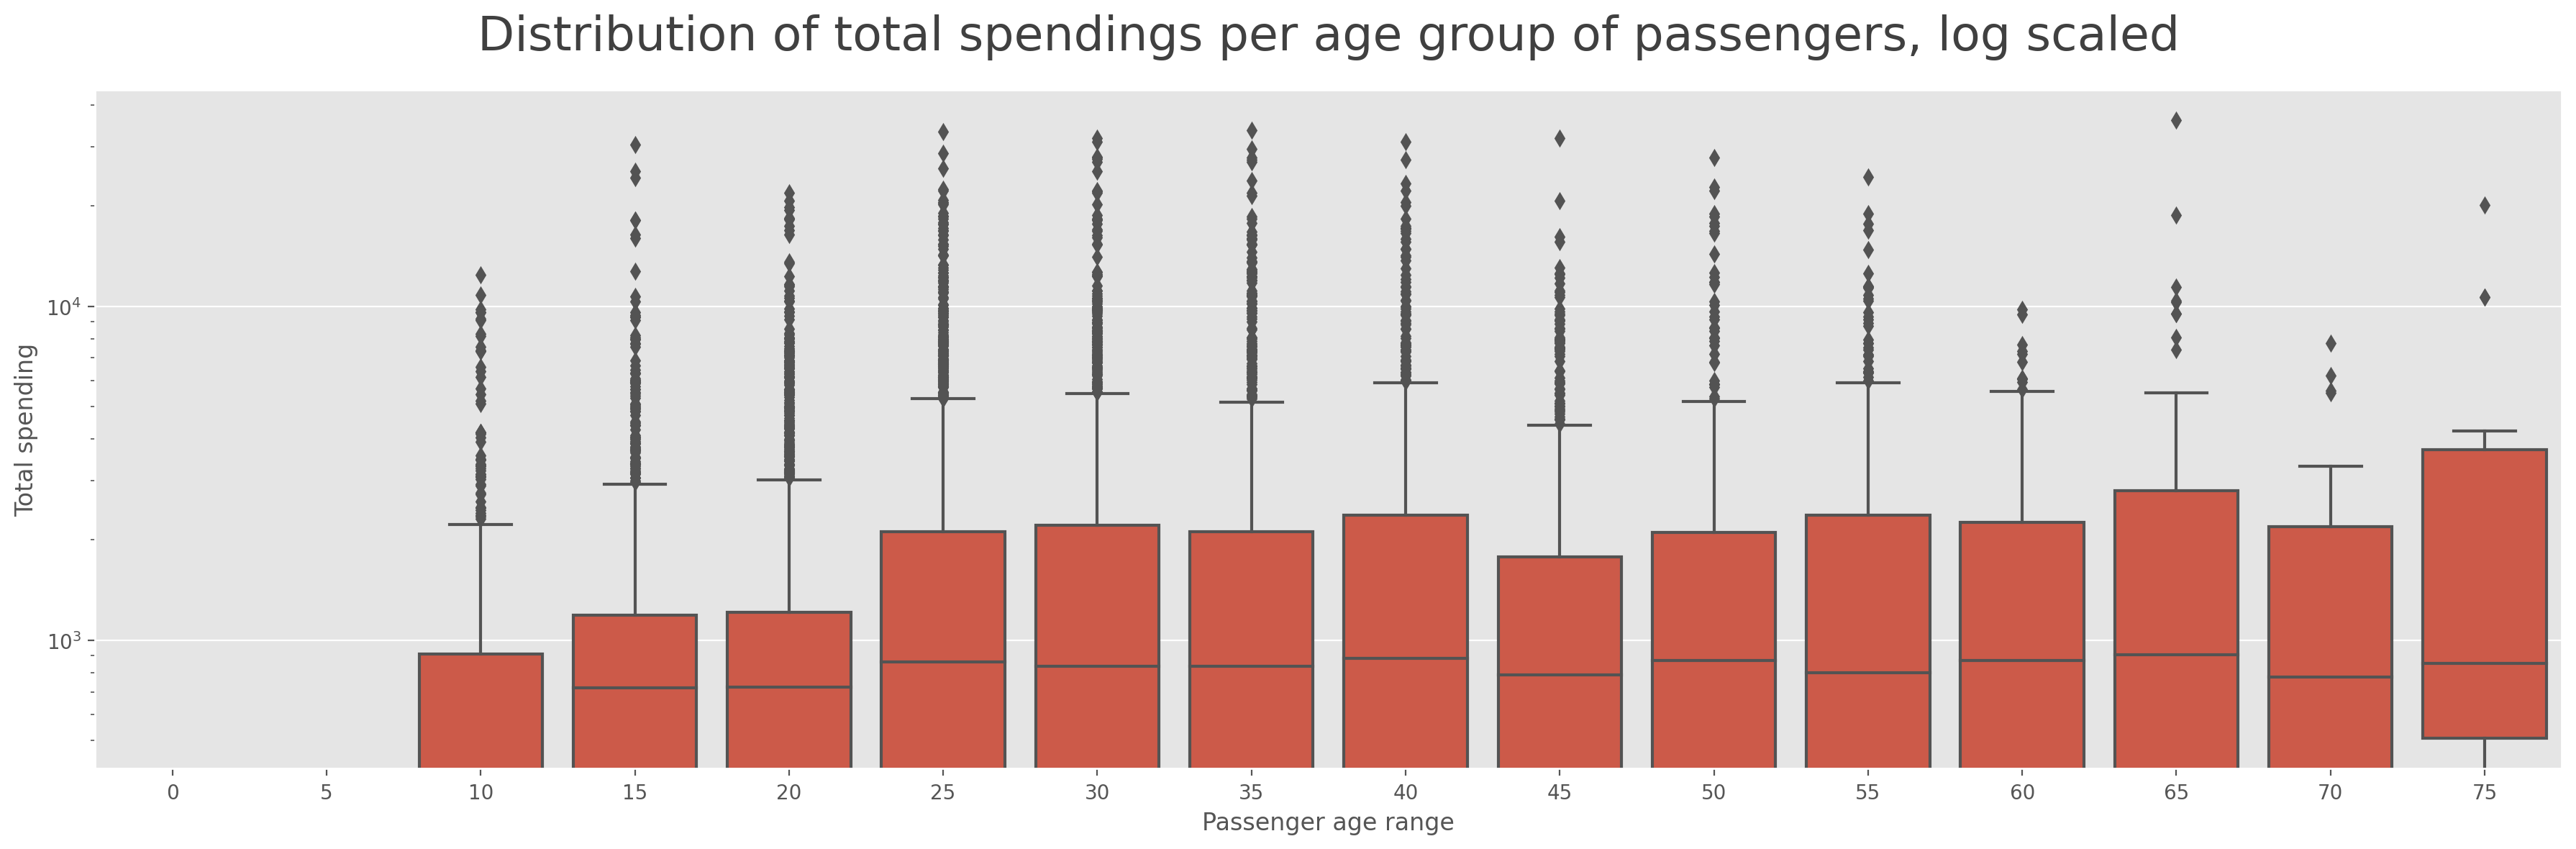

In [76]:
sns.boxplot(data=df, y="spent_total", x="age_bins", color=DEFAULT_COLORS[0])
plt.yscale("log")
plt.title("Distribution of total spendings per age group of passengers, log scaled", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlabel("Passenger age range")
plt.ylabel("Total spending")
plt.tight_layout()
plt.show()

However, if we look at the total spending in the age group we see that the oldest passengers have spent the most money.

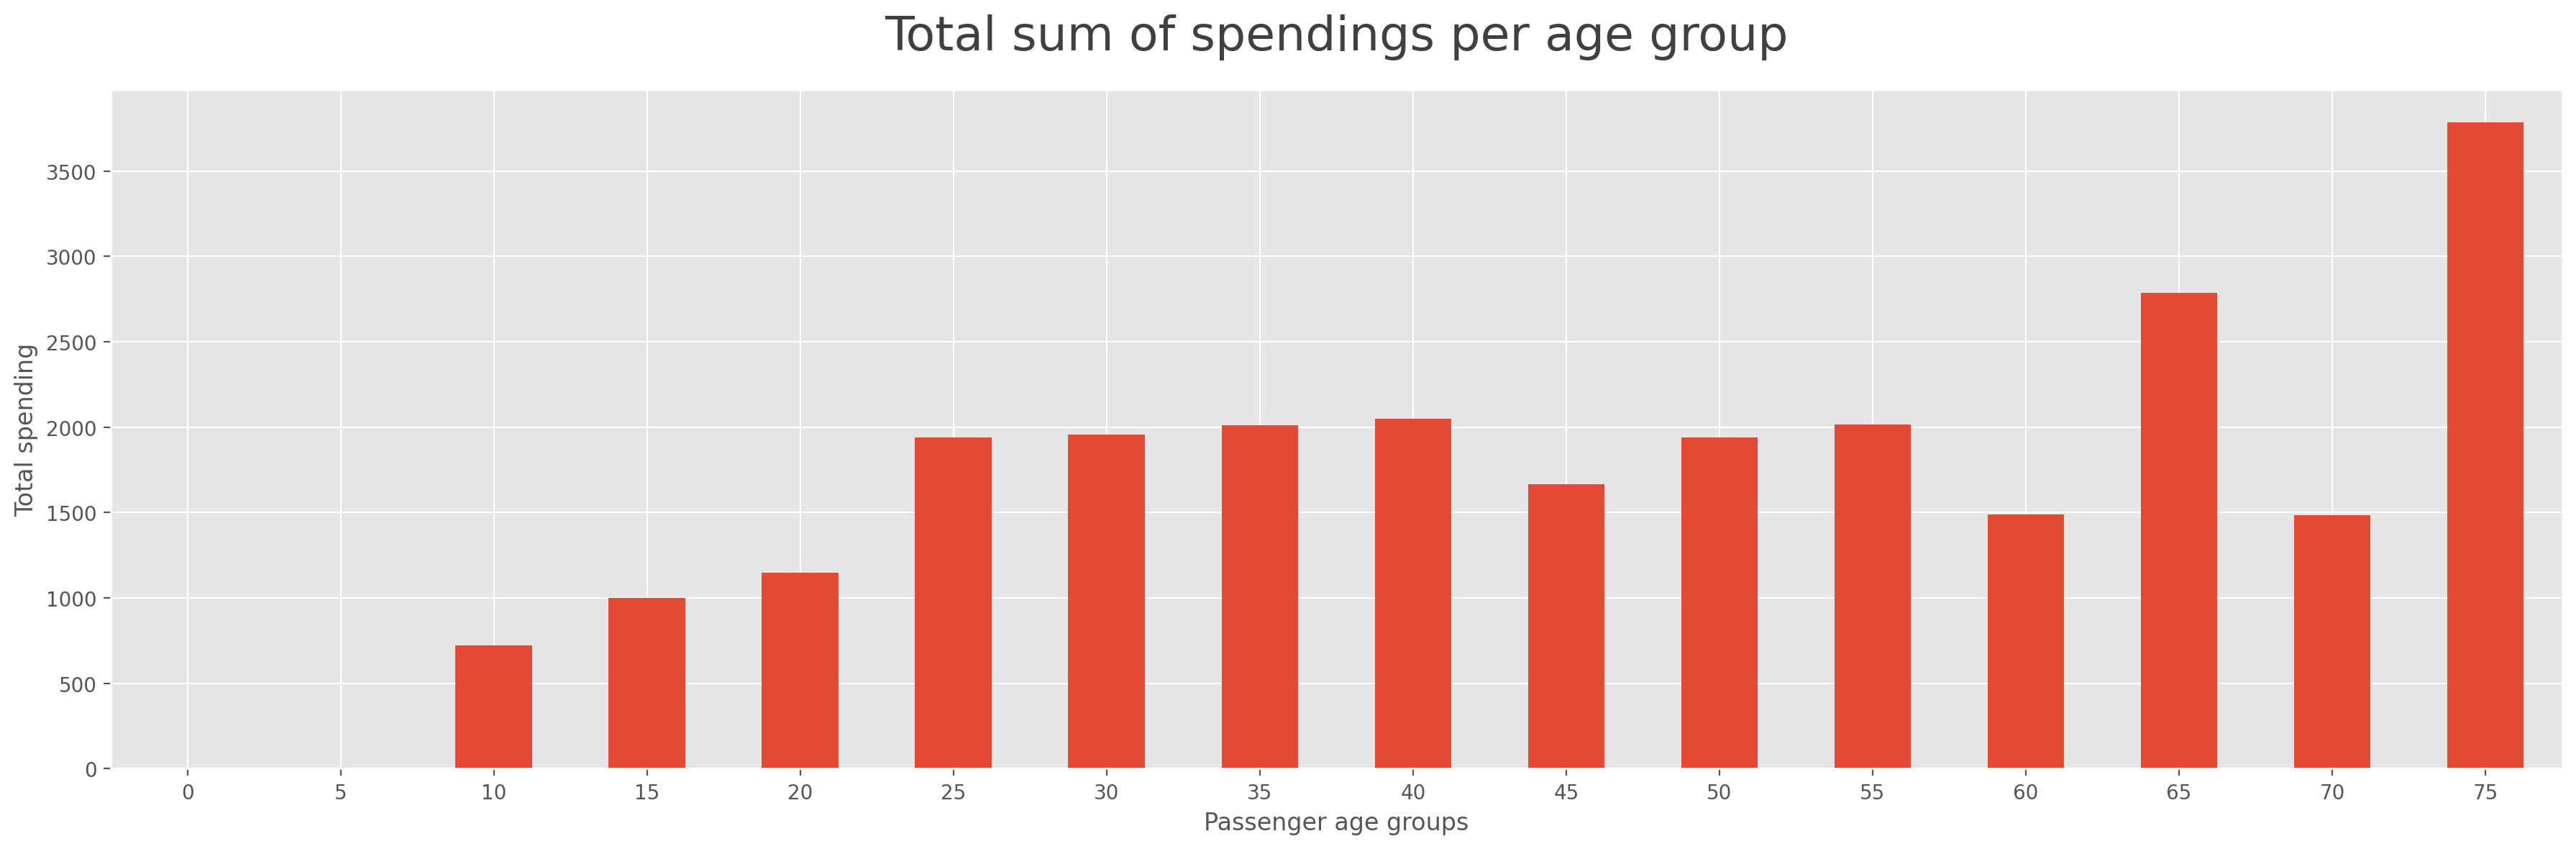

In [77]:
df.groupby("age_bins").spent_total.mean().plot.bar()
plt.xticks(rotation=0)
plt.title("Total sum of spendings per age group", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlabel("Passenger age groups")
plt.ylabel("Total spending")
plt.tight_layout()
plt.show()

#### `name` and derived features

In [78]:
feature = "name"

In [79]:
get_missing(feature)

294 missing values for feature «name» (train: 2.3%, test: 2.2%)


In [80]:
same_name = np.sum(df.name.value_counts()==2)
print(f"There are {same_name} passengers with the same name in the data.")

There are 47 passengers with the same name in the data.


Several last names are very frequent in the data.

In [81]:
print(df.name_last.value_counts()[:15])

Buckentry      19
Belley         19
Hinglendez     18
Fowlesterez    18
Casonston      18
Gibbsonton     17
Mclardson      17
Domington      17
Georgasey      16
Dickley        16
Gainebergan    16
Vloaf          16
Litthews       16
Briggston      16
Haydenzier     16
Name: name_last, dtype: int64


#### `transported`

We almost have class balance in our target variable.

In [82]:
print(df.transported.value_counts())

True     4378
False    4315
Name: transported, dtype: int64


**Correlations to the target variable**

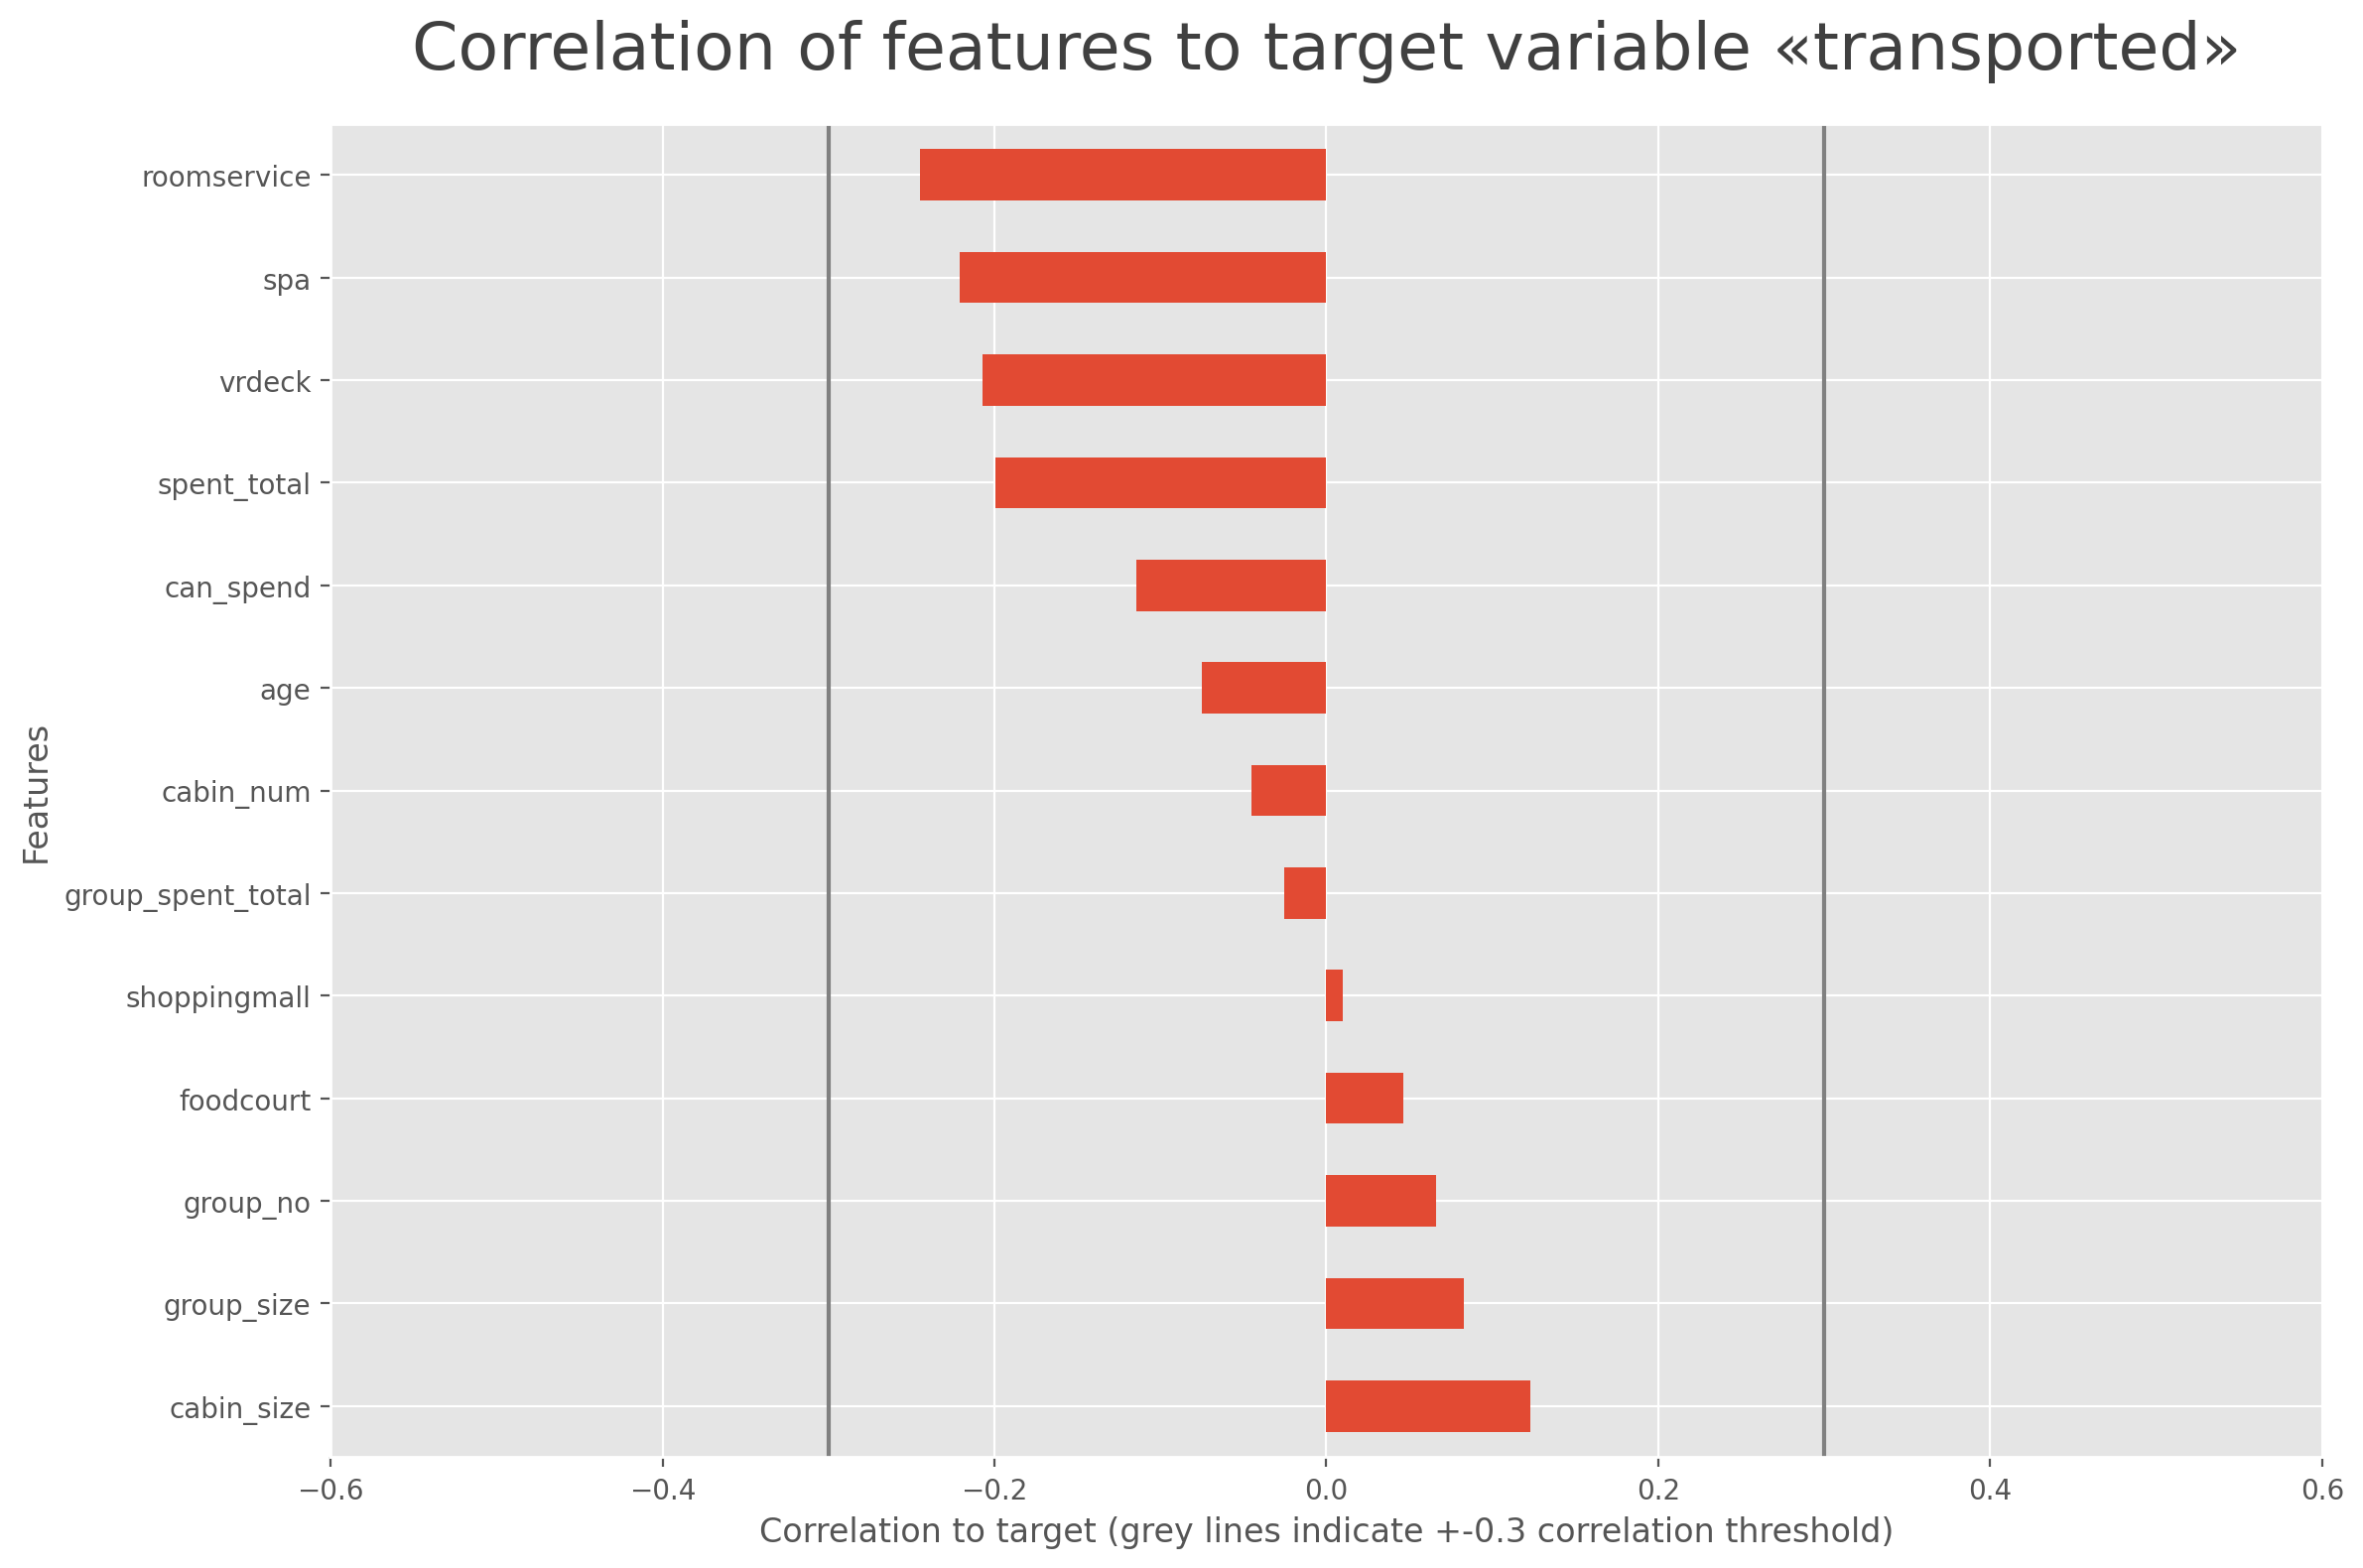

In [83]:
tmp = df.transported.dropna().astype(int)
corr = df.corrwith(tmp, drop=True, numeric_only=True)
corr.sort_values(inplace=True, ascending=False)
correlation_treshold = 0.3 # lower bound for moderate correlation

corr.plot.barh(figsize=(12,8))
plt.title(f"Correlation of features to target variable «transported»", size=TITLE_SIZE, pad=TITLE_PAD)
plt.axvline(-correlation_treshold, color="grey")
plt.axvline(correlation_treshold, color="grey")
plt.xlabel(f"Correlation to target (grey lines indicate +-{correlation_treshold} correlation threshold)")
plt.ylabel("Features")
plt.xlim(-0.6, 0.6)
plt.tight_layout()
plt.show()

# Classification

Prepare data and setup preprocessing pipeline

In [84]:
def create_preprocess(nums, cats_ohe, cats_bool):
    return ColumnTransformer(
                        [("imputer_num", make_pipeline(SimpleImputer(strategy="mean"),), 
                                                       nums),
                         ("imputer_cat_ohe", make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                                       OneHotEncoder(handle_unknown="ignore")), 
                                                       cats_ohe),
                         ("imputer_cat_bool", make_pipeline(SimpleImputer(strategy="most_frequent")), 
                                                       cats_bool),
                        ], remainder="passthrough")

In [85]:
nums =['age', 
       'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 
       'spent_total', "group_size"]

cats_ohe = ['homeplanet', 'destination', 'cabin_deck', 'cabin_side']
cats_bool = ['cryosleep', "vip"]
all_cols = [*nums, *cats_ohe, *cats_bool]

X_train = train[all_cols]
y_train = train.transported.astype(int)
X_test = test[all_cols]

## Baseline

In [86]:
classifiers = [
    DummyClassifier(),
    LogisticRegression(max_iter=1e4, n_jobs=-1),
    RidgeClassifier(max_iter=1000),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(n_jobs=-1),
    SVC(kernel="rbf"),
    RandomForestClassifier(n_jobs=-1),
    lgb.LGBMClassifier(n_jobs=-1)
]

In [87]:
%%time
baseline_results = []
for clf in tqdm(classifiers):
    pipe = make_pipeline(create_preprocess(nums, cats_ohe, cats_bool), clf)
    score = np.mean(cross_val_score(pipe, 
                                    X_train, 
                                    y_train, 
                                    scoring="accuracy", 
                                    cv=5,
                                    n_jobs=-1,
                                   ))
    baseline_results.append((clf, np.round(score, 4)))

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 154 ms, sys: 104 ms, total: 258 ms
Wall time: 4.79 s


LightGBM yields the best result with default hyperparameters. 

In [88]:
results = pd.DataFrame(baseline_results, columns=["clf", "accuracy"])
results.clf = results.clf.apply(lambda x: str(x).split("(")[0])
display(results.sort_values("accuracy", ascending=False).style.hide(axis="index"))

clf,accuracy
LGBMClassifier,0.801200
SVC,0.791800
LogisticRegression,0.786600
RandomForestClassifier,0.784900
RidgeClassifier,0.766900
LinearDiscriminantAnalysis,0.766800
KNeighborsClassifier,0.762700
DummyClassifier,0.503600


In [89]:
clf = lgb.LGBMClassifier(n_jobs=-1)
pipe = make_pipeline(create_preprocess(nums, cats_ohe, cats_bool), clf)
_ = pipe.fit(X_train, y_train)

In [90]:
def make_submission(pipe=pipe, file_name="submission.csv"):
    labels = pipe.predict(X_test)
    labels = [True if x==1 else False for x in labels]
    submission = df[df.transported.isna()]["passengerid"].to_frame()
    submission["labels"] = labels
    submission.columns = ["PassengerId", "Transported"]
    submission.to_csv(file_name, index=False)

The first baseline submission with LGBM yields **0.80219** on the leaderboard.

In [91]:
make_submission(pipe)

## Optimize hyperparameters

We now try to reduce the data to an optimal set of features for modelling.

In [92]:
nums =['age', "group_size", "cabin_size",
       'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 
       "spent_total", ]

cats_ohe = ['homeplanet', 'destination', "cabin_deck", "cabin_side", "age_bins"]
cats_bool = ["cryosleep", "vip", "can_spend"]

all_cols = [*nums, *cats_ohe, *cats_bool]

X_train = df[df.transported.notna()][all_cols]
y_train = df[df.transported.notna()].transported.astype(int)
X_test = df[df.transported.isna()][all_cols]

Grid search optimal hyperparameters

In [93]:
clf = lgb.LGBMClassifier(n_jobs=-1)
pipe = make_pipeline(create_preprocess(nums, cats_ohe, cats_bool), clf)

In [94]:
%%time
search_space = dict(lgbmclassifier__learning_rate=np.logspace(-2.0, -1.2, 10),
                    lgbmclassifier__n_estimators=np.linspace(350, 500, 11).astype(int), 
                    lgbmclassifier__num_leaves=np.linspace(20, 30, 11).astype(int),
                   )

grd_search = GridSearchCV(pipe, 
                          search_space, 
                          scoring="accuracy",
                          cv=5,
                          n_jobs=-1)

_ = grd_search.fit(X_train, y_train)

CPU times: user 38.6 s, sys: 5 s, total: 43.6 s
Wall time: 6min 42s


In [95]:
print(f"Best accuracy from grid search: {grd_search.best_score_:.3f}")
print("Best found hyperparameters:")
print(grd_search.best_params_)

Best accuracy from grid search: 0.807
Best found hyperparameters:
{'lgbmclassifier__learning_rate': 0.015058363542798407, 'lgbmclassifier__n_estimators': 380, 'lgbmclassifier__num_leaves': 25}


A model with optimized hyperparameters yields **0.80313** on the leader board which is at the time of writing among the best quarter of entries.

In [96]:
clf = lgb.LGBMClassifier(num_leaves=24, n_estimators=395, learning_rate=0.015, n_jobs=-1)

pipe = make_pipeline(create_preprocess(nums, cats_ohe, cats_bool), clf)
print(f"{np.mean(cross_val_score(pipe, X_train, y_train)):.4f}")
_ = pipe.fit(X_train, y_train)

0.8054


In [97]:
make_submission(pipe, file_name="submission.csv")

## Permutation importance

In [101]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [102]:
%%time
result = permutation_importance(pipe, 
                                X_train, y_train,
                                scoring="accuracy", 
                                n_repeats=10,
                                random_state=0)

CPU times: user 1min 7s, sys: 11.3 s, total: 1min 19s
Wall time: 11.1 s


By analysing the feature importance with permutation we see that `foodcourt`, `spent_total`, `cryosleep`, `spa`, `vrdeck` and `cabin_deck` rank highly as salient features.

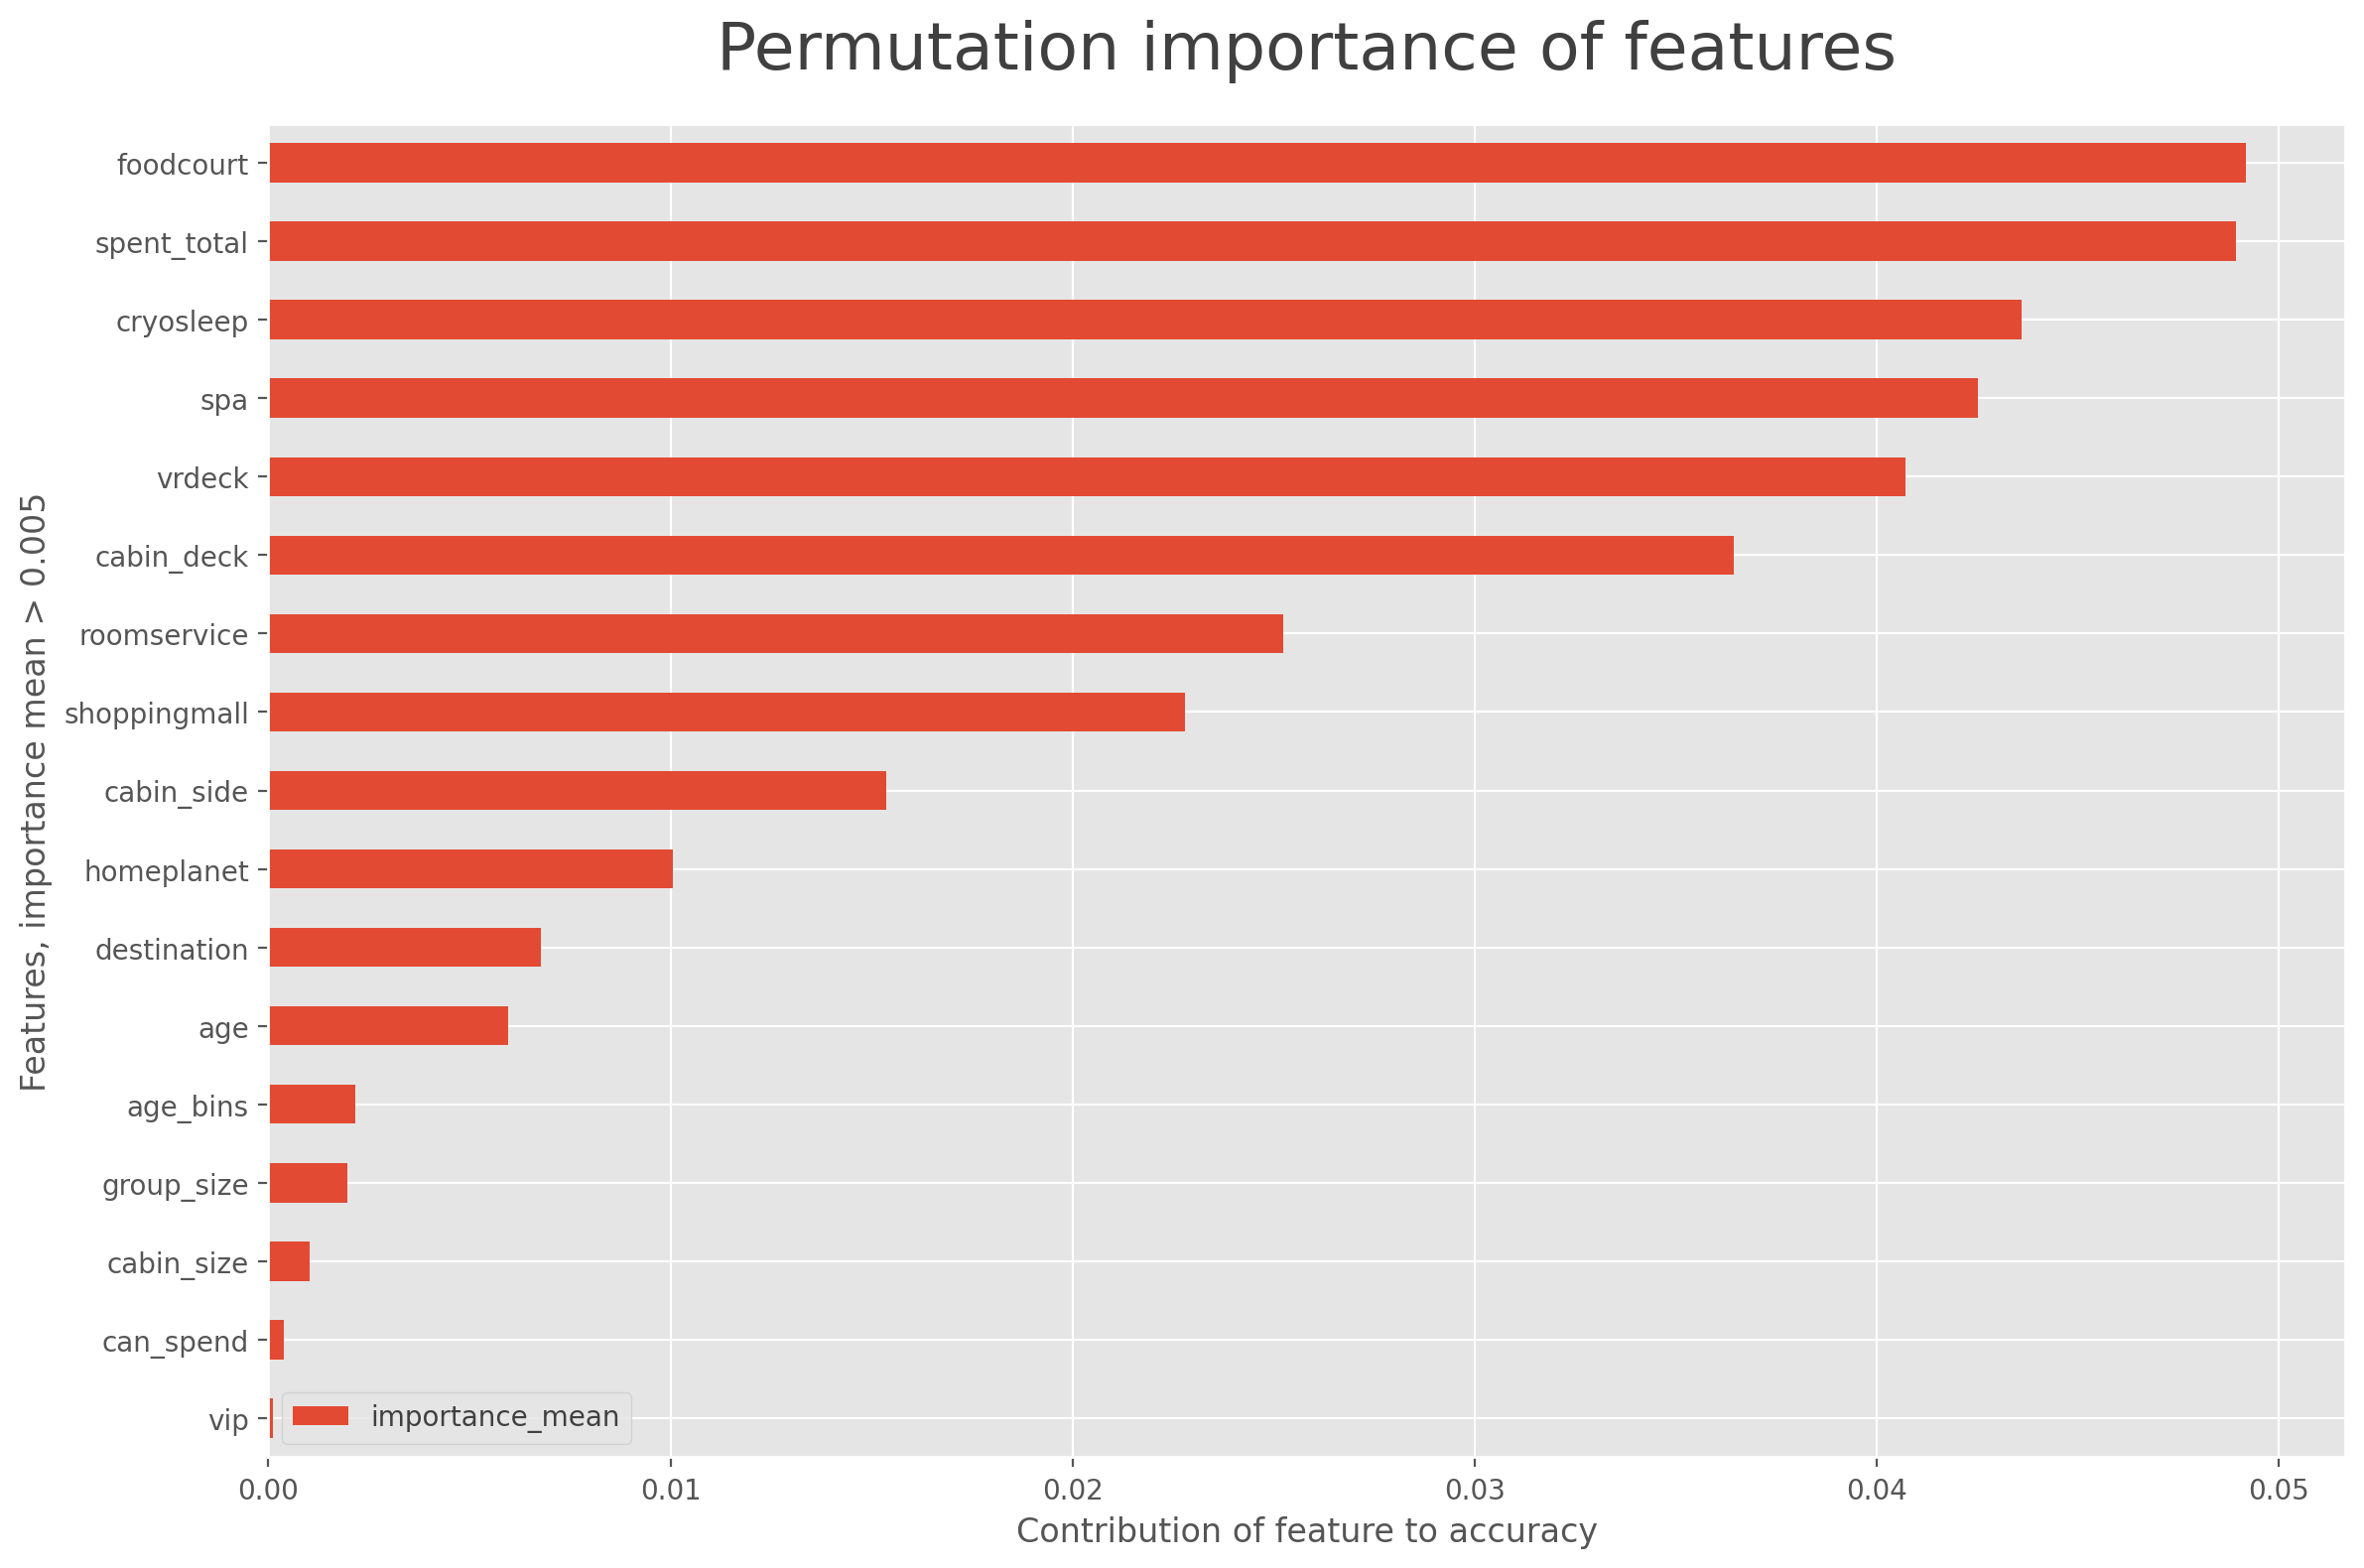

In [103]:
df_results = pd.DataFrame(result["importances_mean"])
df_results.columns = ["importance_mean"]
df_results.sort_values(by="importance_mean", ascending=True, inplace=True)
feature_labels = X_train.columns[df_results.index]

df_results.plot.barh(figsize=(12,8))
plt.yticks(ticks=range(0,len(df_results)), labels=feature_labels)
plt.title("Permutation importance of features", size=TITLE_SIZE, pad=TITLE_PAD)
plt.ylabel("Features, importance mean > 0.005")
plt.xlabel("Contribution of feature to accuracy")
plt.tight_layout()
plt.show()